# Métodos Baseados em Árvores (*Tree-based Methods*)

Prof. Daniel de Abreu Pereira Uhr

### Conteúdo
* Introdução
* Árvore de Decisão
  * Árvore de Regressão (*Regression Trees*);
  * Poda de Árvore de Regressão (*Regression Tree Pruning*);
  * Árvore de Classificação (*Classification Trees*);
  * Poda de Árvore de Classificação (*Classification Tree Pruning*);
* Conjunto de Árvores (Ensemble of Trees)
  * *Bagging* (*Bootstrap Aggregating*);
  * *Random Forests*;
  * *Boosting*;
* Aplicações em *Python*
* Considerações Finais


### Referências

* [An Introduction to Statistical Learning](https://www.statlearning.com/) (ISL) by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani
  * Capítulo 8
* [The Elements of Statistical Learning](https://hastie.su.domains/ElemStatLearn/) (ESL) by Trevor Hastie, Robert Tibshirani and Jerome Friedman
  * Capítulos 15, 16


***Disclaimer:*** *O material apresentado aqui é uma adaptação do material de aula do Prof. Daniel de Abreu Pereira Uhr, e não deve ser utilizado para fins comerciais. O material é disponibilizado para fins educacionais e de pesquisa, e não deve ser reproduzido sem a devida autorização do autor. Este material pode conter erros e imprecisões. O autor não se responsabiliza por quaisquer danos ou prejuízos decorrentes do uso deste material. O uso deste material é de responsabilidade exclusiva do usuário. Caso você encontre erros ou imprecisões neste material, por favor, entre em contato com o autor para que possam ser corrigidos. O autor agradece qualquer feedback ou sugestão de melhoria.*

In [1]:
# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Import
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier, AdaBoostClassifier, AdaBoostRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error

# Modelos Gradient Boosting exta
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Import matplotlib for graphs
import matplotlib.pyplot as plt
# Set global parameters
plt.style.use('seaborn-v0_8-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (12,7)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

### 1. Introdução

Nesta aula, estudaremos os métodos baseados em árvores para modelagem econométrica e aprendizado de máquina (*Machine Learning*), com foco tanto nos aspectos conceituais quanto em aplicações práticas.

Ao final da aula, espera-se que o aluno seja capaz de:

* Compreender o funcionamento de uma ***árvore de decisão*** (árvores de Regressão e de Classificação);
* Compreender o conceito de ***poda de árvore*** e sua importância na prevenção do sobreajuste (*overfitting*);
* Compreender o conceito de ***Bagging*** e como ele contribui para o desempenho dos modelos;
* Entender o funcionamento das ***Random Forests*** e suas vantagens em relação às árvores individuais;
* Compreender o conceito de ***Boosting*** e sua contribuição para a performance preditiva;
* Aplicar os conceitos aprendidos em exemplos práticos utilizando a linguagem *Python*.

### 2. Árvore de Decisão (*Decision Tree*)

As árvores de decisão envolvem a estratificação ou segmentação do espaço dos preditores em regiões simples e distintas. Para realizar uma previsão para uma nova observação, normalmente utilizamos a média (em problemas de regressão) ou a moda (em problemas de classificação) das observações de treinamento que pertencem à mesma região.

Como o conjunto de regras de divisão pode ser representado graficamente por uma estrutura hierárquica em forma de árvore, esses métodos são conhecidos como métodos baseados em árvores de decisão.


### 2.1. Árvore de Regressão (*Regression Trees*)

Vamos introduzir o conceito de árvore de decisão a partir do caso de regressão, onde o ***objetivo é prever uma variável contínua***. As árvores de regressão são construídas ***dividindo o espaço dos preditores em regiões homogêneas***, onde cada região é associada a uma previsão específica. Nosso caso específico envolve prever o salário de jogadores de beisebol com base em duas características: `Hits` (número de rebatidas) e `Years` (número de anos jogados) - *Predicting Baseball Players’ Salaries Using Regression Trees*.


<div style="text-align:center;">
    <img src="images\Fig_8_1.png"  alt="Imagem" style="width: 650px;"/>
</div>


Nesta sessão, consideraremos o conjunto de dados `Hitters`. Ele consiste em dados individuais de jogadores de beisebol. Em nossas aplicações, estamos interessados ​​em prever os salários dos jogadores - *Salary*.

In [3]:
hitters = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Hitters.csv').dropna()
hitters.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N
5,-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,...,501,336,194,A,W,282,421,25,750.0,A


5 linhas × 21 colunas

Em particular, estamos interessados ​​em observar como o número de `Hits` e a anos de experiência (`Years`) preveem o `Salary`. vamos criar uma variável com as variáveis explicativas (features, X) e a variável resposta (target, y):

In [4]:
features = ['Years', 'Hits']
X = hitters[features].values
y = np.log(hitters.Salary.values)

Repare que utilizamos o log(salário), pois ele tem uma distribuição mais gaussiana:

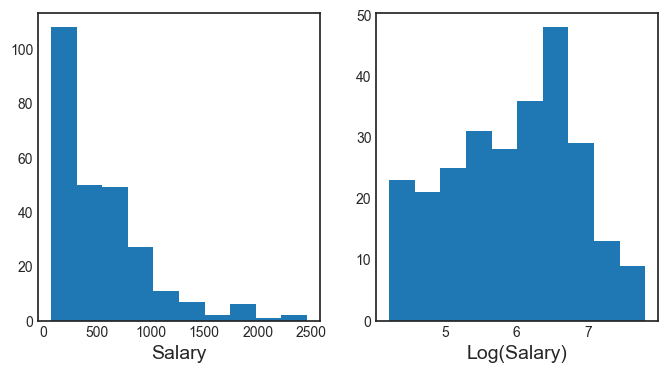

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))

# Plotando a distribuição de salary
ax1.hist(hitters.Salary.values)
ax1.set_xlabel('Salary')
ax2.hist(y)
ax2.set_xlabel('Log(Salary)');

Para entender o que é uma árvore, vamos primeiro dar uma olhada em uma. 

Vamos ajustar uma regressão com no máximo 3 folhas (3 regiões finais de decisão)

In [6]:
# Ajustando a arvore de decisão com 3 folhas
tree = DecisionTreeRegressor(max_leaf_nodes=3)
# treinando a arvore de decisão
tree.fit(X, y)

DecisionTreeRegressor(max_leaf_nodes=3)

Agora, vamos plotar os resultados visualmente. Repare que a maior vantagem da árvore é a interpretabilidade.

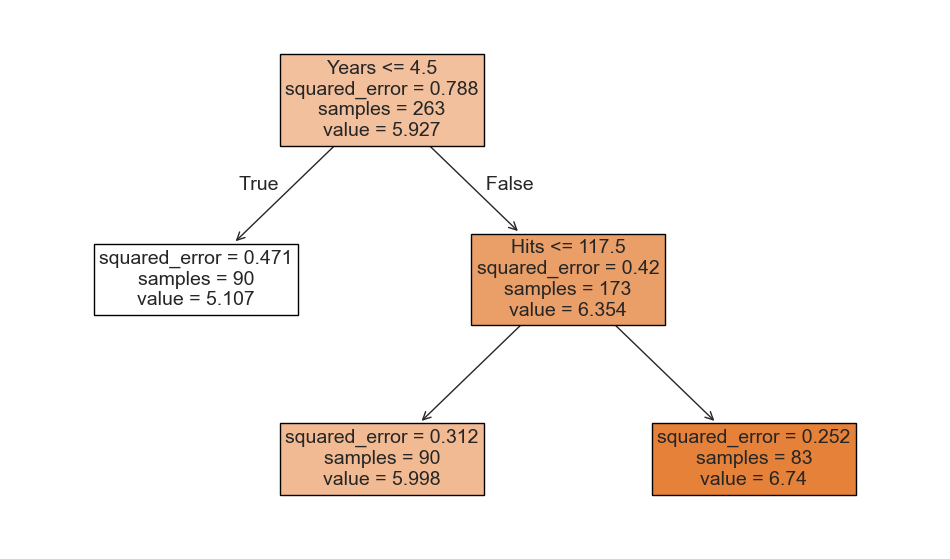

In [7]:
# Figura 8.1
fig, ax = plt.subplots(1,1)
ax.set_title('Figure 8.1');

# Plot tree
plot_tree(tree, filled=True, feature_names=features, fontsize=14, ax=ax);

***Raiz da Árvore***

O primeiro critério de divisão escolhido pelo algoritmo foi a variável Years (anos de experiência).
* A divisão ocorre em dois grupos:
  * Jogadores com Years ≤ 4.5 (ramo esquerdo)
  * Jogadores com Years > 4.5 (ramo direito)
* No nó da raiz, temos:
  * squared_error = 0.788: erro quadrático médio (variância) dos salários dentro do grupo inteiro (antes da divisão).
  * samples = 263: número total de jogadores considerados neste ponto.
  * value = 5.927: média dos salários (em log ou milhares de dólares) de todos os jogadores no conjunto original.

***Ramo Esquerdo (Years ≤ 4.5)***

Como não há divisão adicional, esse nó se torna uma folha.

* Valores:
  * squared_error = 0.471
  * samples = 90
  * value = 5.107: salário médio dos jogadores com até 4,5 anos de experiência.

Isso significa que todas as observações que satisfazem Years ≤ 4.5 caem nessa folha, e recebem a predição de salário igual a 5.107.

***Ramo Direito (Years > 4.5)***

Esse nó passa por uma nova divisão baseada na variável Hits (número de rebatidas):
* Hits ≤ 117.5: ramo esquerdo
* Hits > 117.5: ramo direito
* Valores no nó intermediário:
  * squared_error = 0.42
  * samples = 173
  * value = 6.354: média dos salários entre os jogadores com mais de 4,5 anos de experiência.


***Folha esquerda do nó direito (Hits ≤ 117.5)***

* squared_error = 0.312
* samples = 90
* value = 5.998

Jogadores com mais de 4,5 anos de experiência e menos de 117,5 rebatidas têm salário médio de 5.998.


***Folha direita do nó direito (Hits > 117.5)***

* squared_error = 0.252
* samples = 83
* value = 6.740

Jogadores com mais de 4,5 anos de experiência e mais de 117,5 rebatidas têm salário médio de 6.740.


No geral, ***a árvore estratifica ou segmenta os jogadores*** em três regiões do espaço preditor:

* jogadores que jogaram por quatro anos ou menos
* jogadores que jogaram por cinco ou mais anos e que fizeram menos de 118 rebatidas no ano passado, e
* jogadores que jogaram por cinco anos ou mais e que fizeram pelo menos 118 rebatidas no ano passado.


Essas três regiões podem ser escritas como:

* $R1 = \{X | Years<4,5 \}$
* $R2 = \{X | Years>=4,5, Hits<117,5\}$, e
* $R3 = \{X | Years>=4,5, Hits>=117,5\}$.

Podemos visualizar o espaço e as regiões em um gráfico bidimensional:

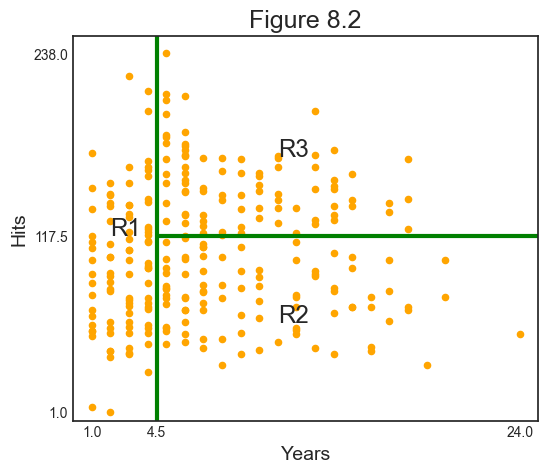

In [8]:
# Figura 8.2
def make_figure_8_2():
    
    # Init
    hitters.plot('Years', 'Hits', kind='scatter', color='orange', figsize=(6,5))
    plt.title('Figure 8.2')
    plt.xlim(0,25); plt.ylim(ymin=-5);
    plt.xticks([1, 4.5, 24]); plt.yticks([1, 117.5, 238]);

    # Split lines
    plt.vlines(4.5, ymin=-5, ymax=250, color='g')
    plt.hlines(117.5, xmin=4.5, xmax=25, color='g')

    # Regions
    plt.annotate('R1', xy=(2,117.5), fontsize='xx-large')
    plt.annotate('R2', xy=(11,60), fontsize='xx-large')
    plt.annotate('R3', xy=(11,170), fontsize='xx-large');

make_figure_8_2()

**Procedimento genérico para construção de uma árvore**

A cada etapa, fazemos:

1. Selecionamos o preditor $X_j$ e o ponto de corte $s$;
2. Dividimos o espaço preditor nas regiões:
   - $R_1(j, s) = \{ X \mid X_j < s \}$
   - $R_2(j, s) = \{ X \mid X_j \geq s \}$

3. Calculamos a **RSS total** após a divisão:

$$
\sum_{i: x_i \in R_1(j, s)} (y_i - \hat{y}_{R_1})^2 + \sum_{i: x_i \in R_2(j, s)} (y_i - \hat{y}_{R_2})^2
$$

4. Repetimos os passos acima para **todos os preditores** e **todos os possíveis valores de corte $s$**, escolhendo aquele que **minimiza a soma total do erro**:

$$
\arg \min_{j, s} \left\{ \sum_{i: x_i \in R_1(j, s)} (y_i - \hat{y}_{R_1})^2 + \sum_{i: x_i \in R_2(j, s)} (y_i - \hat{y}_{R_2})^2 \right\}
$$

5. Repetimos esse processo recursivamente, dividindo as regiões formadas, até que alguma **condição de parada** seja atingida (como número mínimo de observações por folha ou profundidade máxima da árvore).


### 2.2. Poda da Árvore de Regressão (*Regression Tree Pruning*)

O processo de construção de uma árvore de regressão, como vimos anteriormente, pode resultar em uma árvore muito complexa, com várias divisões. Embora essa complexidade permita que o modelo se ajuste muito bem aos dados de treinamento, ela frequentemente leva ao problema conhecido como ***overfitting*** (ou sobreajuste). Nesse caso, a árvore "aprende" os ruídos e variações específicas do conjunto de treinamento, perdendo capacidade de generalização.

Em termos estatísticos, uma árvore muito complexa tende a apresentar ***baixa variância in-sample*** (no conjunto de treino), mas ***alta variância out-of-sample*** (no conjunto de teste), resultando em desempenho preditivo inferior.

Uma estratégia para mitigar esse problema é a ***poda da árvore (pruning)***, que consiste em reduzir o número de divisões (ou folhas) da árvore com o ***objetivo de diminuir a variância*** fora da amostra e, ***aumentar a capacidade de generalização***.
* A ***Poda se assemelha à regularização***, onde buscamos um modelo mais simples que ainda capture a essência dos dados, mas com menos complexidade.

Podemos ver isso acontecendo se construirmos a mesma árvore anterior, entretanto com 5 folhas.

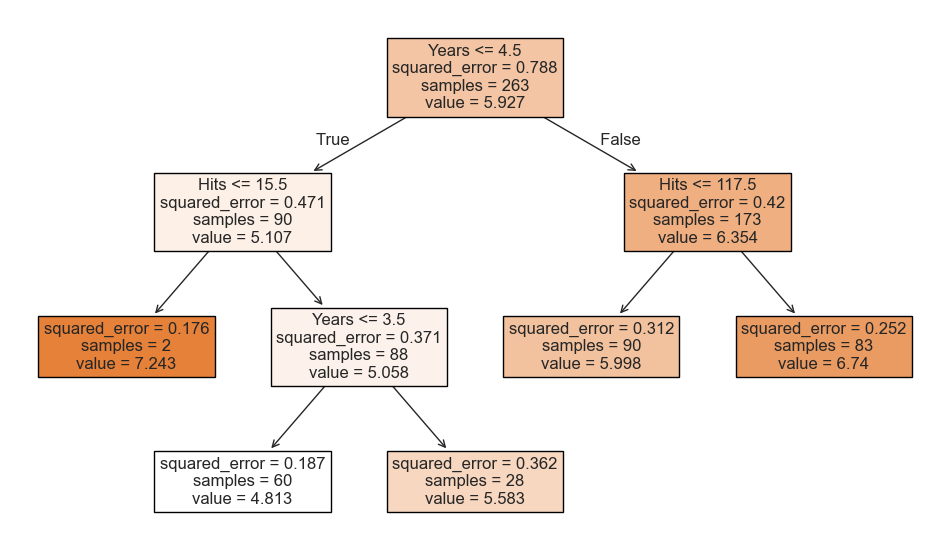

In [9]:
# Compute tree
overfit_tree = DecisionTreeRegressor(max_leaf_nodes=5).fit(X, y)
# Plot tree
fig, ax = plt.subplots(1,1)
plot_tree(overfit_tree, filled=True, feature_names=features, fontsize=12, ax=ax);

Na nova árvore, observamos que a divisão mais à esquerda produz uma previsão de $Salary = 7.243$ para jogadores com pouca experiência (*Years*) e poucos *Hits*. No entanto, essa predição é baseada em apenas 2 observações, o que sugere que provavelmente são outliers. Isso é um ***indício de que a árvore está superajustada ao conjunto de treinamento***.

***Restringindo o número mínimo de observações por folha***

Uma maneira de evitar esse tipo de superajuste é ***exigir que cada folha tenha um número mínimo de observações***. Por exemplo, vamos ajustar uma árvore com no máximo 5 folhas, mas exigindo pelo menos 10 observações por folha:

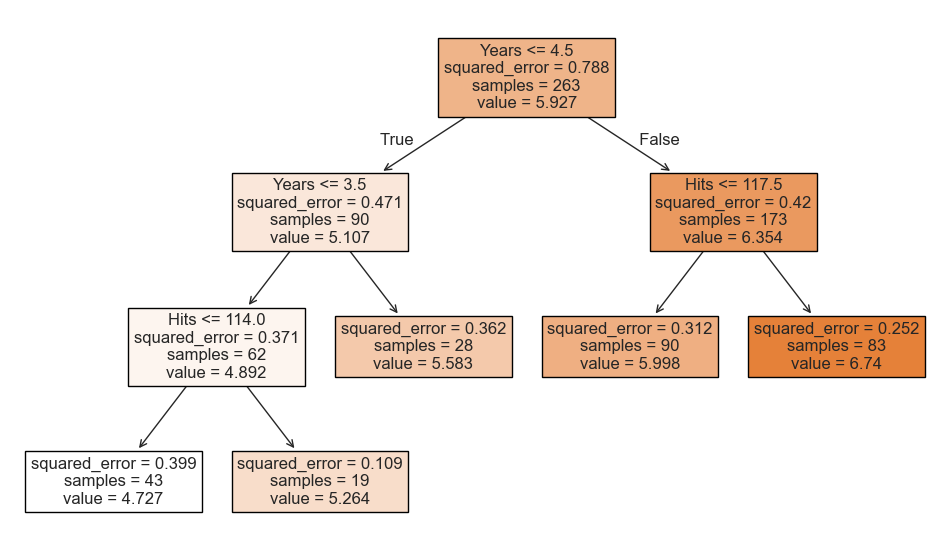

In [10]:
# Compute tree
no_overfit_tree = DecisionTreeRegressor(max_leaf_nodes=5, min_samples_leaf=10).fit(X, y)

# Plot tree
fig, ax = plt.subplots(1,1)
plot_tree(no_overfit_tree, filled=True, feature_names=features, fontsize=12, ax=ax);

Agora, a árvore resultante é mais estável e interpretável:

* Jogadores com menos experiência (*Years*) e menos rebatidas (*Hits*) tendem a ter salários mais baixos.
* Essa relação é evidenciada visualmente pelos tons de cor se tornando mais escuros à medida que nos movemos da esquerda (menores salários) para a direita (salários mais altos).

***Outras abordagens para controle da complexidade***

Uma alternativa à imposição de um número mínimo de observações por folha é ***permitir que a árvore cresça apenas enquanto a redução no RSS*** (*residual sum of squares*) proporcionada por uma divisão for ***superior a um determinado limiar***. Essa estratégia tende a produzir árvores menores, mas pode ser míope, pois uma divisão pouco informativa no início pode dar origem a subdivisões boas posteriormente.

Certo, até aqui entendemos o conceito de àrvore, e vimos a importância da poda para evitar o sobreajuste. Além disso, vimos que é possivel controlar a complexidade da árvore através de restrições como o número mínimo de observações por folha ou um limiar de redução do RSS.

Entretanto, como podemos escolher o ponto de corte ideal para a árvore? Ou seja, como podemos determinar o número ideal de folhas?

***Escolhendo o tamanho ótimo da árvore: Validação cruzada***

Uma ***abordagem mais robusta*** para definir o tamanho ideal da árvore é utilizar **validação cruzada**, comparando o desempenho preditivo de árvores com diferentes profundidades ou números de folhas. Nas próximas etapas, vamos explorar esse caminho, utilizando dados de treinamento e teste, além de incluir novas variáveis explicativas.

In [79]:
# Import original split
features = ['Years', 'Hits', 'RBI', 'PutOuts', 'Walks', 'Runs', 'AtBat', 'HmRun']

In [81]:
X_train = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Hitters_X_train.csv').dropna()[features]

In [82]:
X_test = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Hitters_X_test.csv').dropna()[features]

In [83]:
y_train = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Hitters_y_train.csv').dropna()

In [85]:
y_test = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Hitters_y_test.csv').dropna()

***OBS: Se der erro ao carregar o dataset, execute o comando mais vezes até que ele carregue corretamente.***

Esse código Python abaixo faz uma busca pelo número ideal de folhas (`max_leaf_nodes`) para uma árvore de regressão, utilizando validação cruzada com o objetivo de minimizar o erro de previsão. 

* Vamos avaliar o desempenho do modelo `DecisionTreeRegressor` para diferentes tamanhos de árvore (número de folhas de 2 a 10), comparando o erro de:
  * Treinamento
  * Teste
  * Validação cruzada (com 6 folds)
  
Por fim, ele identifica o melhor número de folhas com base no menor erro de validação cruzada.

In [14]:
params = range(2,11)
reg_scores = np.zeros((len(params),3))
best_score = 10**6

# Loop over all parameters
for i,k in enumerate(params):
    
    # Model
    tree = DecisionTreeRegressor(max_leaf_nodes=k)

    # Loop over splits
    tree.fit(X_train, y_train)
    reg_scores[i,0] = mean_squared_error(tree.predict(X_train), y_train)
    reg_scores[i,1] = mean_squared_error(tree.predict(X_test), y_test)

    # Get CV score
    kf6 = KFold(n_splits=6)
    reg_scores[i,2] = -cross_val_score(tree, X_train, y_train, cv=kf6, scoring='neg_mean_squared_error').mean()
    
    # Save best model
    if reg_scores[i,2]<best_score:
        best_model = tree
        best_score = reg_scores[i,2]

Agora, vamos gerar uma figura com dois gráficos lado a lado para ilustrar visualmente:
* O desempenho dos modelos com diferentes números de folhas (gráfico à esquerda);
* A árvore de decisão que obteve o melhor resultado de validação cruzada (gráfico à direita).

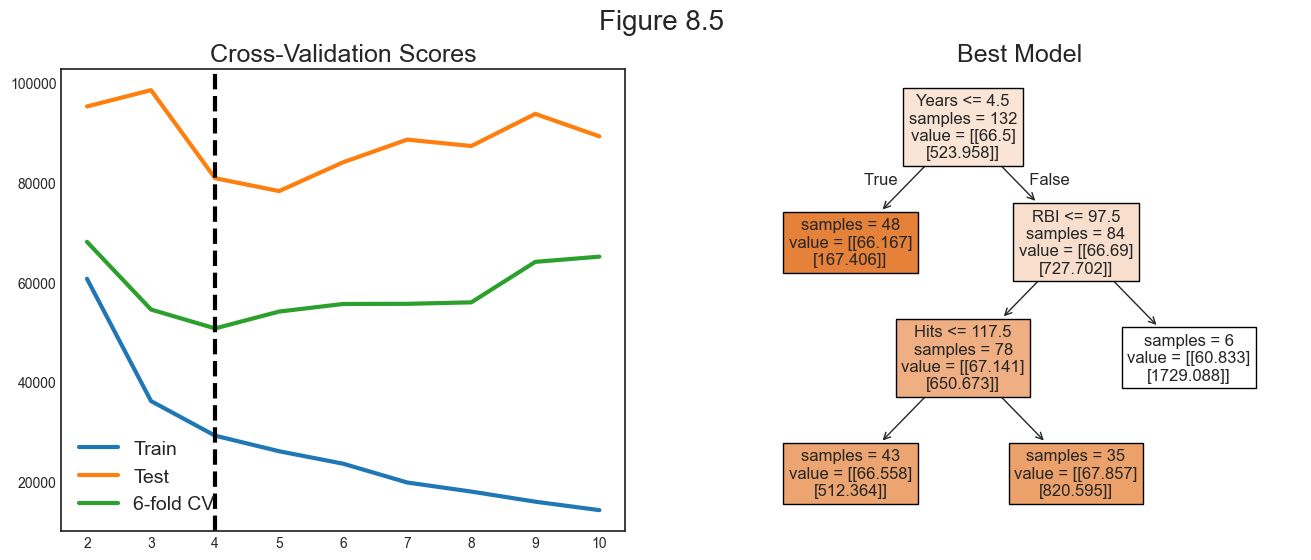

In [15]:
# Figura 8.5
def make_figure_8_5():
    
    # Init
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
    fig.suptitle('Figure 8.5')

    # Plot scores
    ax1.plot(params, reg_scores);
    ax1.axvline(params[np.argmin(reg_scores[:,2])], c='k', ls='--')
    ax1.legend(['Train','Test','6-fold CV']);
    ax1.set_title('Cross-Validation Scores');

    # Plot best tree
    plot_tree(best_model, filled=True, impurity=False, feature_names=features, fontsize=12, ax=ax2);
    ax2.set_title('Best Model');

make_figure_8_5()

Descrição do Gráfico:
* Eixo X: Número de folhas da árvore (`max_leaf_nodes`) variando de 2 a 10.
* Eixo Y: Erro quadrático médio (*lembrando: "quanto menor, melhor"*).

Interpretação do Gráfico:
* O erro de treino (linha azul) diminui continuamente conforme o número de folhas aumenta. Isso é esperado: quanto mais complexa a árvore, melhor ela "memoriza" o conjunto de treinamento.
* O erro de teste (laranja) e o erro de validação cruzada (verde) atingem um mínimo próximo de 4 folhas. Depois disso, começam a subir — sinal de *overfitting*.
* A linha vertical tracejada preta marca o ponto ótimo escolhido pela validação cruzada (número de folhas que minimiza o erro médio em CV, aqui: 4 folhas).

A árvore à direita representa o modelo vencedor (com 4 folhas), e pode ser usada como preditor final. 

### 2.3. Árvore de Classificação (*Classification Trees*)

Uma árvore de classificação é conceitualmente semelhante a uma árvore de regressão, mas é utilizada quando a variável resposta é qualitativa (ou categórica), em vez de quantitativa. A ideia central é a mesma: segmentar o espaço dos preditores em regiões, mas agora o modelo prevê que cada observação pertença à classe mais comum entre as observações de treinamento dentro da mesma região terminal (folha).

>O processo de construção de uma árvore de classificação é estruturalmente semelhante ao de uma árvore de regressão. No entanto, há uma diferença fundamental: como o objetivo agora é prever categorias (e não valores contínuos), o critério usado para escolher as divisões precisa ser diferente.

Em seu lugar, utilizamos ***medidas de impureza***, que indicam o grau de heterogeneidade de um nó. Quanto mais "puro" for o nó (isto é, quanto mais ele concentrar observações de uma única classe), melhor é a divisão.

* Vamos considerar $\hat{p}_{mk}$ a proporção de observações de treinamento no nó $m$ que pertencem à classe $k$.
  * Por exmeplo, se temos um nó com 100 observações, onde 70 são da classe A e 30 da classe B, então $\hat{p}_{mA} = 0.7$ e $\hat{p}_{mB} = 0.3$.

**Métricas de Impureza**

Três métricas comuns para avaliar a qualidade das divisões são:

***Taxa de Erro de Classificação***

Mede a proporção de observações que não pertencem à classe majoritária dentro do nó:

$$
\text{Taxa de Erro} = 1 - \max_k \hat{p}_{mk}
$$

* ***Quanto menor a taxa de erro, mais puro é o nó***.
* Para o exemplo acima, a taxa de erro seria $1 - 0.7 = 0.3$ (30% das observações não pertencem à classe A).

***Índice de Gini***

O índice de Gini mede a probabilidade de que duas observações escolhidas aleatoriamente pertençam a classes diferentes:
$$
\text{Índice de Gini} = 1 - \sum_k \hat{p}_{mk}^2
$$

* Para o exemplo acima, o índice de Gini seria $1 - (0.7^2 + 0.3^2) = 1 - (0.49 + 0.09) = 0.42$.
* ***Quanto menor o índice de Gini, mais puro é o nó***.

***Entropia (ou Impureza de Shannon)***

A entropia mede a incerteza ou aleatoriedade das classes dentro do nó:
$$
\text{Entropia} = -\sum_k \hat{p}_{mk} \log(\hat{p}_{mk})
$$

* Por exemplo, para o caso acima, a entropia seria $- (0.7 \log(0.7) + 0.3 \log(0.3)) \approx 0.88$.
* ***Quanto menor a entropia, mais puro é o nó***.

***Qual medida usar na prática?***

Na prática, o ***Índice de Gini*** e a ***Entropia*** são os critérios mais usados durante a construção da árvore, pois são mais sensíveis a mudanças na pureza dos nós. A Taxa de Erro de Classificação, por ser menos sensível, é utilizada apenas na etapa de avaliação final do desempenho do classificador.


***Ganho de Pureza (ou Redução da Impureza)***

Durante a construção da árvore, o algoritmo avalia todas as possíveis divisões em todas as variáveis. Para cada divisão possível, ele calcula o quanto a impureza diminui após a divisão. Esse valor é chamado de Ganho de Pureza, e representa a diferença entre a impureza antes da divisão e a média ponderada das impurezas dos nós filhos.

$$
\text{Ganho de Pureza} = \text{Impureza do Nó Original} - \left( \frac{N_1}{N} \cdot \text{Impureza do Nó 1} + \frac{N_2}{N} \cdot \text{Impureza do Nó 2} \right)
$$
onde:
* $N$ é o número total de observações no nó original;
* $N_1$ e $N_2$ são o número de observações nos nós resultantes da divisão;
* $\text{Impureza do Nó Original}$ é a impureza do nó antes da divisão;
* $\text{Impureza do Nó 1}$ e $\text{Impureza do Nó 2}$ são as impurezas dos nós resultantes.

O algoritmo escolhe a divisão que **maximiza o ganho de pureza**, buscando criar nós cada vez mais homogêneos. Uma divisão só é considerada vantajosa se o **ganho de pureza for positivo**, ou seja, se a **impureza média ponderada dos nós filhos for menor do que a impureza do nó original**. 

Se o ganho de pureza for **zero ou negativo**, significa que a divisão **não trouxe melhoria na homogeneidade dos grupos**, e por isso o algoritmo **não realizará esse split**. Essa lógica garante que a árvore só cresce quando há uma **redução efetiva da impureza**, buscando criar nós cada vez mais puros a cada etapa da construção.

Logo, o critério de divisão em árvores de decisão é local e recursivo


***Exemplo Prático: Dados de Insuficiência Cardíaca***

Vamos trabalhar com o conjunto de dados **Heart**, que contém informações clínicas de pacientes. O objetivo é prever a ocorrência de **doença cardíaca** (variável **ADH**), que é **binária** (*Sim* ou *Não*), a partir do conjunto de características observáveis/preditores/*features*: utilizaremos variáveis como idade, pressão arterial, nível de colesterol, entre outras.

Nosso objetivo é construir uma árvore de classificação capaz de prever corretamente se um paciente possui ou não histórico de doença cardíaca.

In [16]:
heart = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Heart.csv').drop('Unnamed: 0', axis=1).dropna()
heart.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


OBS: Novamente, caso não carregue, execute o comando mais vezes até que ele carregue corretamente.

Repare que a coluna `heart['ChestPain']` e `heart['Thal']` contém valores categóricos não numéricos. Para utilizar esses dados em uma árvore de decisão, precisamos convertê-los em variáveis numéricas. Vamos fazer isso utilizando o método `factorize()` do Pandas, que converte categorias em números inteiros.
* `pd.factorize()` atribui números em ordem de aparição, sem considerar qualquer ordem inerente nas categorias (ex.: "baixo", "médio", "alto"). Se a ordem importa, considere outras técnicas, como OrdinalEncoder ou mapeamento manual.

In [17]:
# "Factorizar" as variáveis categóricas
heart.ChestPain = pd.factorize(heart.ChestPain)[0]
heart.Thal = pd.factorize(heart.Thal)[0]

o `pd.factorize()` com `[0]` retorna os códigos numéricos das categorias, enquanto [1] retorna os rótulos originais. Aqui, estamos interessados apenas nos códigos numéricos.

In [18]:
# criar uma lista com os nomes das variáveis explicativas (features)
features = [col for col in heart.columns if col!='AHD']

In [19]:
features

['Age',
 'Sex',
 'ChestPain',
 'RestBP',
 'Chol',
 'Fbs',
 'RestECG',
 'MaxHR',
 'ExAng',
 'Oldpeak',
 'Slope',
 'Ca',
 'Thal']

In [20]:
# Definir X e y
X2 = heart[features]
y2 = pd.factorize(heart.AHD)[0]

Agora ajustamos nosso classificador. Sem profundidade máxima (`max_depth=None`), ***a árvore pode crescer e se ajustar aos dados de treinamento***. Vamos apenas limitar em um numero máximo de 11 folhas.

In [21]:
# Fit classification tree
clf = DecisionTreeClassifier(max_depth=None, max_leaf_nodes=11)
clf.fit(X2,y2)

DecisionTreeClassifier(max_leaf_nodes=11)

***Acurácia***

Para avaliar o desempenho do modelo, utilizamos a métrica de **acurácia**, que mede a proporção de previsões corretas em relação ao total de previsões feitas. 

$$
\text{Acurácia} = \frac{\text{Número de Acertos}}{\text{Número Total de Observações}}
$$


Qual é a pontuação da acurácia da nossa árvore do exemplo?

In [22]:
# Final score
clf.score(X2,y2)

0.8686868686868687

O resultado mostra que a árvore de decisão alcançou uma acurácia de 0.8686..., indicando que 86,87% das previsões feitas pelo modelo estão corretas.

Vamos dar uma olhada na árvore inteira.

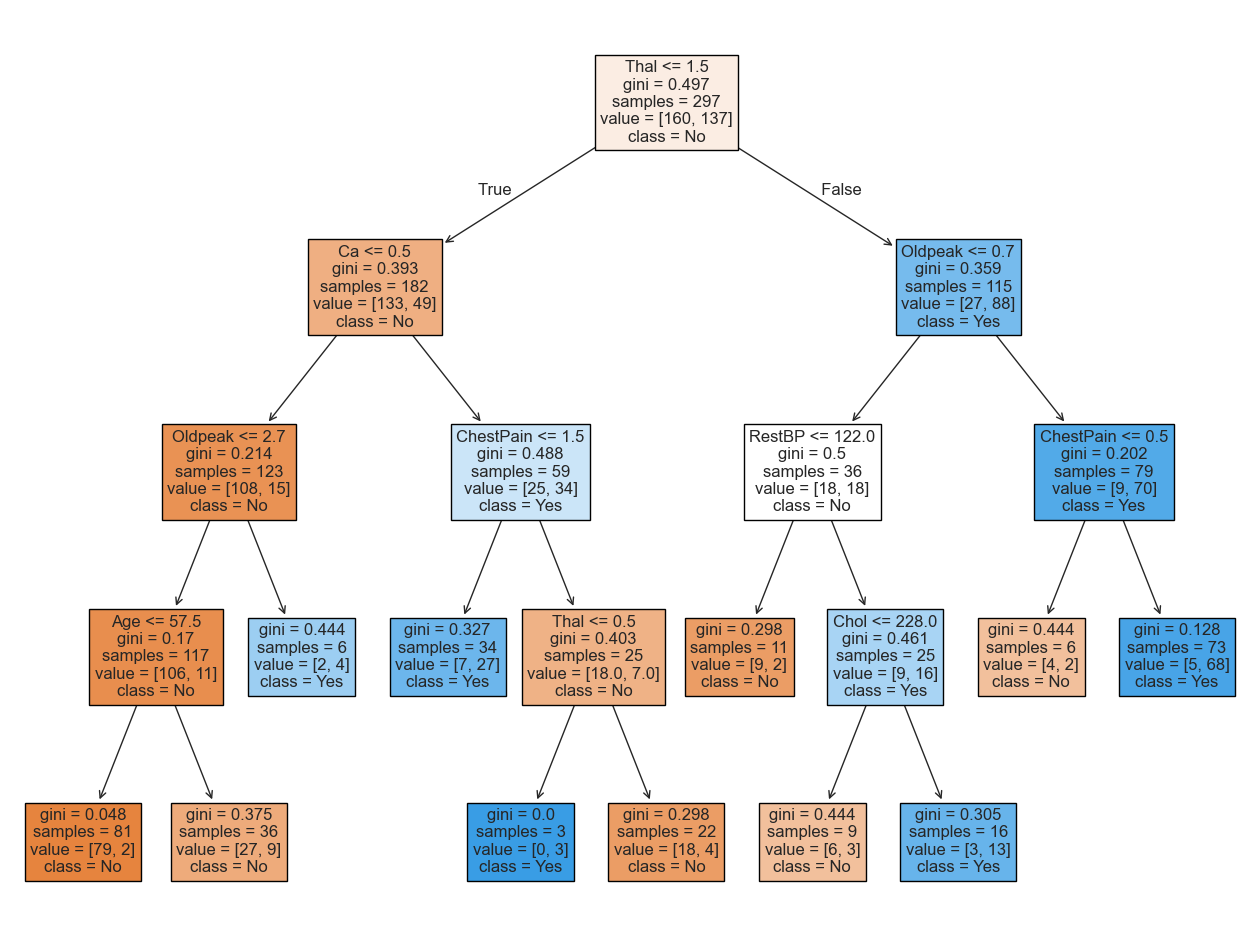

In [23]:
# Figura 8.6 a
def make_fig_8_6a():
    
    # Init
    fig, ax = plt.subplots(1,1, figsize=(16,12))
    ax.set_title('Figure 8.6');

    # Plot tree
    plot_tree(clf, filled=True, feature_names=features, class_names=['No','Yes'], fontsize=12, ax=ax);

make_fig_8_6a()    

**Avaliando a Árvore de Decisão**

Observe o nó de decisão $Age <= 57.5$, ***localizado na parte inferior esquerda***. Ele divide o grupo de 117 amostras em dois novos nós-folha. Repare que ambos os nós-folha têm a mesma previsão final: `class = No`.

***A pergunta natural que surge é:*** Se ambos os caminhos levam à mesma classificação, por que o algoritmo se deu ao trabalho de fazer essa divisão?

A resposta está em um conceito fundamental que vai além da simples classificação: a pureza dos nós.

Vamos olhar os dados com atenção:
* Folha da Esquerda ($Age <= 57.5$ é Verdadeiro):
  * Temos 81 amostras, das quais 79 são "Não" e apenas 2 são "Sim".
  * A probabilidade de uma amostra aqui ser "Sim" é de apenas 2/81, ou $~2.5\% $.
  * A previsão "Não" aqui é feita com altíssima confiança.
* Folha da Direita ($Age <= 57.5$ é Falso):
  * Temos 36 amostras, das quais 27 são "Não" e 9 são "Sim".
  * A probabilidade de uma amostra aqui ser "Sim" é de 9/36, ou $25\% $.
  * A previsão continua sendo "Não" (pois $27 > 9$), mas nossa certeza é bem menor.
* Conclusão: O Algoritmo Prefere a Certeza ao Erro Mínimo (Imediato)

Fica claro que a divisão $Age <= 57.5$ é útil. Ela conseguiu isolar um grupo de 81 pacientes sobre os quais podemos afirmar com muita certeza que o resultado é "Não", separando-os de um grupo menor e mais incerto.

É aqui que entram as ***métricas de construção da árvore, como o Índice Gini*** e a ***Entropia***. Lembre que o algoritmo não está apenas tentando minimizar o número de classificações erradas no conjunto de treino; ele está ***tentando criar os grupos mais homogêneos (ou "puros") possíveis a cada passo***.

Uma divisão que aumenta a pureza, como esta, é considerada vantajosa e será realizada, pois:
* Reduz o Índice Gini geral (Ganho de Pureza).
  * A folha da esquerda ficou quase pura (Gini = 0.048, altíssima pureza).
  * A folha da direita continua com alguma mistura (Gini = 0.375), mas globalmente o Gini médio ponderado caiu em relação ao nó antes da divisão (que tinha Gini = 0.17).
* Aumenta o poder preditivo do modelo para novos dados, pois nos dá uma estimativa de probabilidade, e não apenas uma classificação "seca".

Em resumo: A árvore não busca apenas o quê prever, mas também quão confiante ela está nessa previsão. Essa divisão, embora não altere a classe prevista, aprimora a confiança do modelo em suas próprias previsões.

### 2.4. Poda da Árvore de Classificação (*Classification Tree Pruning*)

Assim como nas árvores de regressão, o processo de poda também pode ser aplicado às árvores de classificação. O objetivo é controlar a complexidade do modelo, prevenindo o *overfitting* e melhorando a capacidade de generalização.

Nesta seção, utilizamos o hiperparâmetro `max_leaf_nodes`, que define o número máximo de nós-folha permitidos na árvore.

In [24]:
# Figure 8.6 b
def make_figure_8_6b():
    
    # Init
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6))
    fig.suptitle('Figure 8.6')

    # Plot scores
    ax1.plot(params, clf_scores);
    ax1.legend(['Train','Test','6-fold CV']);

    # Plot best tree
    plot_tree(best_model, filled=True, impurity=False, feature_names=features, fontsize=12, ax=ax2);

Configuração do Experimento:
* objetivo: Encontrar o valor de k (número máximo de folhas da árvore) que minimiza o erro de validação cruzada (e, consequentemente, melhora a capacidade preditiva da árvore).
* Hiperparâmetro avaliado: max_leaf_nodes ∈ {2, 3, ..., 10}
* Repetições: Cada configuração é avaliada em 10 iterações com diferentes divisões treino/teste.
* Métrica de desempenho: reduzir o ***Erro de classificação*** (calculado como $1 - \text{Acurácia} = \frac{N_{\text{Previsões Incorretas}}}{N_{\text{Total Observações}}}$).
* Validação cruzada: Utilizaremos uma 6-fold cross-validation (K=6) para estimar o erro de generalização.

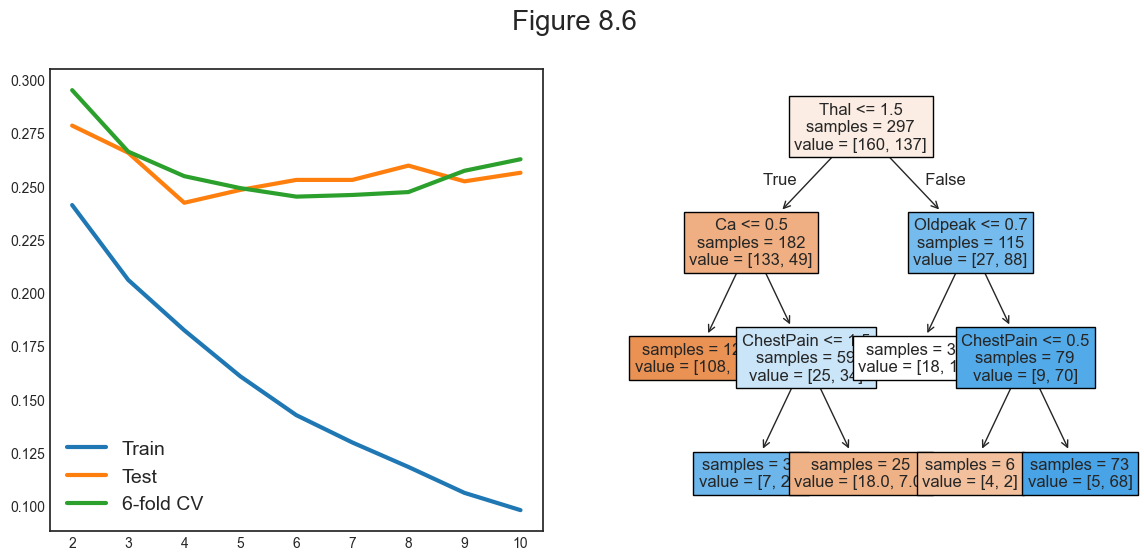

In [25]:
np.random.seed(42)

J = 10
params = range(2, 11)
clf_scores = np.zeros((len(params), 3))

# Loop over all parameters
for i, k in enumerate(params):
    
    # Model
    tree = DecisionTreeClassifier(max_leaf_nodes=k)
    
    # Loop J times
    temp_scores = np.zeros((J, 3))
    for j in range(J):

        # Split
        X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.5, random_state=j)
        m = tree.fit(X2_train, y2_train)

        # Erro de classificação (1 - acurácia)
        temp_scores[j, 0] = 1 - accuracy_score(y2_train, m.predict(X2_train))
        temp_scores[j, 1] = 1 - accuracy_score(y2_test, m.predict(X2_test))

        # Validação cruzada
        kf6 = KFold(n_splits=6)
        cv_error = 1 - cross_val_score(tree, X2_train, y2_train, cv=kf6, scoring='accuracy').mean()
        temp_scores[j, 2] = cv_error

    # Média dos erros para cada k
    clf_scores[i, :] = np.mean(temp_scores, axis=0)

# >>> Escolha do melhor k DEPOIS do loop <<<

best_k = params[np.argmin(clf_scores[:, 2])]
best_model = DecisionTreeClassifier(max_leaf_nodes=best_k).fit(X2, y2)

# Plot da figura
make_figure_8_6b()


***O Gráfico (Esquerda)***

* ***Eixo X:*** Mostra a complexidade do Modelo. O hiperparâmetro `max_leaf_nodes` (o número máximo de nós-folha), que varia de 2 a 10. Quanto mais folhas, mais complexa e "profunda" a árvore pode ser.
* ***Eixo Y:*** Mostra o erro do modelo. Utilizamos o erro de acurácia (`1 - accuracy_score`), onde um valor menor indica um desempenho melhor.

O Gráfico exibe três curvas distintas:
  * Train (Azul - Erro de Treino): O erro do modelo nos mesmos dados que ele usou para aprender.
  * Test (Laranja - Erro de Teste): O erro do modelo em dados novos, que ele nunca viu antes (`X2_test`). Esta é a medida mais importante do poder de generalização do modelo.
  * 6-fold CV (Verde - Erro de Validação Cruzada): Uma estimativa mais robusta do erro de teste. Em vez de usar um único conjunto de teste, a validação cruzada (neste caso, com 6 "dobras" ou `KFold(n_splits=6)`) cria múltiplas divisões de treino/validação para gerar uma média de desempenho mais estável.

O ponto ideal de complexidade é aquele que minimiza o erro de validação cruzada (CV) ou de teste. No gráfico, vemos que o menor erro ocorre quando a árvore tem 6 nós-folha.

***A Árvore (Direita)***

A árvore de decisão mostrada à direita é o resultado final deste processo de otimização.

Ela possui exatamente 6 nós-folha (as caixas na base da árvore), que foi o número identificado como ótimo pelo Gráfico. Ela representa o melhor equilíbrio encontrado: ela é complexa o suficiente para capturar as relações importantes nos dados (Oldpeak, Ca, etc.), mas não tão complexa a ponto de sofrer *overfitting*. Ou seja, ***é o modelo com a maior probabilidade de generalizar bem para novas observações***.

### 3. Conjunto de Árvores (*Ensemble of Trees*)

Anteriormente estávamos modelando uma única árvore de decisão. Do ponto de vista teórico, uma única árvore de decisão pode ser muito instável, pois pequenas variações nos dados podem levar a grandes mudanças na estrutura da árvore. 

Em outras palavras, a utilização de uma única árvore é questionável se os dados de treinamento tiverem valores atípicos ou ruídos, isso pode resultar em um modelo que não generaliza bem para novos dados. Ou seja, o modelo apresentará alta variância, o que significa que ele pode se ajustar muito bem aos dados de treinamento, mas falhar em prever novos dados.

Nesse sentido, surgiram os ***métodos de ensemble (métodos de conjunto)***, que combinam várias árvores de decisão. Esses métodos são importantes para lidar com a variabilidade e a instabilidade das árvores individuais.

Os principais métodos de *ensemble* que veremos são:

* ***Bagging (Bootstrap Aggregating)***: Combina previsões de várias árvores treinadas em subconjuntos aleatórios dos dados.
* ***Florestas Aleatórias (Random Forests)***: Uma extensão do *Bagging* que introduz aleatoriedade adicional na seleção de variáveis para cada divisão. Aumento da diversidade entre as árvores, com ***foco na redução da variância*** do modelo final.
* ***Boosting***: Um método que ajusta ***sequencialmente*** árvores de decisão, onde cada árvore posterior tenta corrigir os erros de previsão da árvore anterior. O foco do modelo está na ***redução do viés***. Ou seja, melhorando a precisão preditiva ao focar nos erros cometidos pelas árvores anteriores.


OBS: Em material complementar temos o ***BART*** (*Bayesian Additive Regression Trees*): Um modelo que combina a flexibilidade das árvores de decisão com a robustez da inferência bayesiana, permitindo uma modelagem robusta e interpretável.


### 3.1. *Bagging* (*Bootstrap Aggregating* / Ensacamento)

O nome *Bagging* vem de *Bootstrap Aggregating*, que é uma técnica que combina previsões de várias árvores de decisão para melhorar a precisão e reduzir a variância. A ideia é treinar várias árvores em subconjuntos aleatórios dos dados (provenientes da técnica de *bootstraping*) e, em seguida, combinar suas previsões.


<div style="text-align:center;">
    <img src="images\img_bagging_.png"  alt="Imagem" style="width: 650px;"/>
</div>



Ele funciona da seguinte maneira:

1. **Bootstrap**: Cria múltiplos subconjuntos de dados de treinamento a partir do conjunto original ($B$), selecionando aleatoriamente com reposição. Isso significa que algumas observações podem aparecer mais de uma vez em um subconjunto, enquanto outras podem não aparecer.
    * OBS: aproximadamente 36.8% das observações originais (em média) não aparecerão em uma amostra bootstrap específica. Isso se aplica a cada amostra bootstrap gerada para cada árvore no Bagging.
2. **Treinamento de Múltiplas Árvores**: Para cada subconjunto gerado, uma árvore de decisão é treinada. Isso resulta em várias árvores, cada uma treinada em um conjunto ligeiramente diferente de dados ($\hat{f}^{*}(.)$).
3. **Agregação**: As previsões de todas as árvores são combinadas para fazer uma previsão final. Para problemas de regressão, isso geralmente é feito calculando a média das previsões de todas as árvores. Para problemas de classificação, a classe mais frequente (votação majoritária) é escolhida.

$$
\hat{f}_{\text{bagging}}(x) = \frac{1}{B} \sum_{b=1}^{B} \hat{f}^{*b}(x)
$$

Em resumo, ***esse método obtem mais precisão porque ao treinar árvores em diferentes subconjuntos de dados, cada árvore individual pode ter um alto viés e/ou alta variância. No entanto, quando as previsões dessas árvores "ruidosas" são agregadas, os erros aleatórios tendem a se cancelar, resultando em um modelo combinado mais estável e com menor variância***. 

***Out-of-Bag (OOB)***

Uma característica muito útil do *Bagging* é a capacidade de estimar o erro de generalização do modelo sem a necessidade de um conjunto de validação separado ou validação cruzada. Isso é feito através do ***erro Out-of-Bag (OOB)***. Como cada árvore no *Bagging* é treinada em um subconjunto *bootstrap* dos dados, algumas observações nunca são usadas para treinar uma árvore específica. Essas observações 'fora da bolsa' (*out-of-bag*) para uma dada árvore podem ser usadas como um conjunto de validação para essa árvore. 

O erro OOB é a média das previsões dessas observações OOB em todas as árvores, fornecendo uma estimativa não viesada do erro de teste do modelo. Em outras palavras, ***cada observação do conjunto original de treino*** terá sua própria previsão OOB (feita a partir das árvores nas quais ela foi OOB), e depois o erro final será a média dos erros de todas essas observações.

Pode-se demonstrar que, com B suficientemente grande, o erro OOB é virtualmente equivalente ao erro de validação cruzada "leave-one-out". A abordagem OOB para estimar o erro de teste é particularmente conveniente ao realizar bagging em grandes conjuntos de dados para os quais a validação cruzada seria computacionalmente onerosa.


***Resumo***

Para cada observação, fazemos o seguinte:

* Pegamos apenas as árvores onde ela foi OOB.
* Fazemos a previsão para ela usando apenas essas árvores.
* Comparamos a predição com o valor real.
* Depois, ao final, calculamos a média do erro considerando todas as observações.


***Exemplo Prático: Bagging com o Conjunto de Dados Heart***

Agora vamos calcular a Acurácia do modelo para o conjunto de dados `Heart` usando diferentes números de árvores.

In [26]:
np.random.seed(42)

params = range(2,50)
bagging_scores = np.zeros((len(params),2))
J = 30;

# Loop over parameters
for i, k in enumerate(params):
    print("Computing k=%1.0f" % k, end ="")
    
    # Repeat J 
    temp_scores = np.zeros((J,2))
    for j in range(J):
        X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.5, random_state=j)
        bagging = BaggingClassifier(DecisionTreeClassifier(), n_estimators=k, oob_score=True)
        bagging.fit(X2_train,y2_train)
        temp_scores[j,0] = bagging.score(X2_test, y2_test)
        temp_scores[j,1] = bagging.oob_score_

    # Average
    bagging_scores[i,:] = np.mean(temp_scores, axis=0)
    print("", end="\r")

A seguir, apresentamos o gráfico que ilustra a performance do modelo *Bagging* no conjunto de dados `Heart`, comparando a acurácia entre o conjunto de teste, e a estimativa *Out-of-Bag* (OOB). Ambos em função do número de árvores.

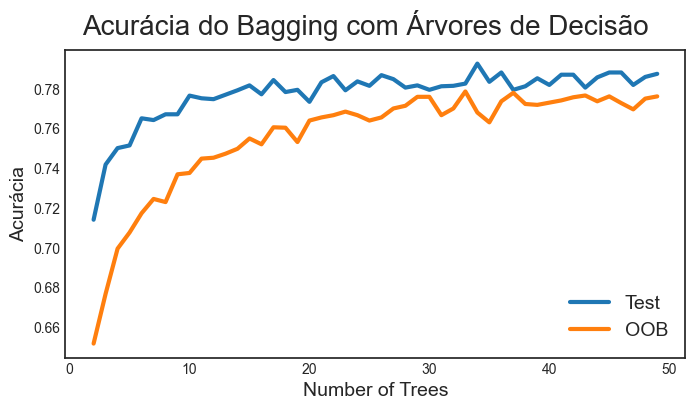

In [35]:
def make_new_figure_1():
    
    fig, ax = plt.subplots(1,1,figsize=(8,4))
    fig.suptitle("Acurácia do Bagging com Árvores de Decisão")

    # Plot scores
    ax.plot(params, bagging_scores);
    ax.legend(['Test','OOB']);
    ax.set_xlabel('Number of Trees'); ax.set_ylabel('Acurácia');

make_new_figure_1()

* ***Test:*** É a performance do modelo *Bagging* completo (o *ensemble* de todas as k árvores) avaliada em um conjunto de dados de teste (ou validação) completamente separado e independente do conjunto de treinamento.
* ***OOB:*** É uma estimativa da performance do modelo em dados não vistos que é calculada internamente durante o processo de treinamento do *Bagging*, sem a necessidade de um conjunto de teste separado.

***Lembre que agora não podemos mais desenhar árvores, pois temos muitas delas***.

No entanto, é possível obter um resumo geral da importância de cada preditor usando o RSS (para árvores de regressão *Bagging*) ou o *Índice de Gini* (para árvores de classificação *bagging*). No caso de árvores de regressão *Bagging*, podemos registrar a quantidade total de redução do RSS devido a divisões em um determinado preditor, calculada a média de todas as árvores. Um valor alto indica um preditor importante. Da mesma forma, no contexto de árvores de classificação *Bagging*, podemos somar a quantidade total de redução do Índice de Gini devido a divisões em um determinado preditor, calculada a média de todas as árvores.

***Importância das Variáveis***

Uma vez treinado o modelo, podemos avaliar quais variáveis explicativas tiveram maior impacto nas decisões tomadas pelas árvores, seja em problemas de classificação ou de regressão.

Essa avaliação é feita medindo quanto cada variável contribuiu para reduzir a impureza em cada divisão realizada ao longo de todas as árvores do ensemble.

* No caso de classificação, a impureza geralmente é medida por métricas como o Índice de Gini ou a Entropia.
* No caso de regressão, a métrica de impureza costuma ser a variância residual dentro dos nós.

Para cada variável, o modelo calcula a soma total das reduções de impureza associadas a ela em todas as árvores.
Essas somas são então normalizadas, resultando em uma pontuação de importância relativa para cada variável, que reflete ***o quanto aquela variável foi útil para a construção da árvore em termos de melhoria da pureza ou redução do erro***.

Essa análise de importância das variáveis é útil em problemas com grande número de preditores, pois permite ao pesquisador identificar quais variáveis têm maior poder explicativo para o modelo, auxiliando tanto na interpretação quanto em possíveis etapas de seleção de variáveis.

In [27]:
# Compute feature importance
feature_importances = np.mean([tree.feature_importances_ for tree in bagging.estimators_], axis=0)

Vejamos a importância relativa de cada característica específica no nosso exemplo aplicado.

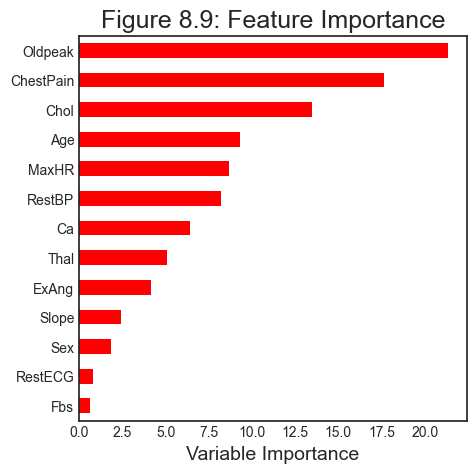

In [28]:
def make_figure_8_9():
    
    # Init
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    ax.set_title('Figure 8.9: Feature Importance');

    # Plot feature importance
    h1 = pd.DataFrame({'Importance':feature_importances*100}, index=features)
    h1 = h1.sort_values(by='Importance', axis=0, ascending=True)
    h1.plot(kind='barh', color='r', ax=ax)
    ax.set_xlabel('Variable Importance'); 
    plt.yticks(fontsize=10);
    plt.gca().legend_ = None;

make_figure_8_9()

### 3.2. Florestas Aleatórias (*Random Forests*)

As Florestas Aleatórias são uma extensão do método de *Bagging* que introduz uma modificação importante com o objetivo de ***reduzir a correlação entre as árvores da floresta, o que leva a uma redução ainda maior da variância do modelo final***.
* Ou seja, há um objetivo de diminuir a sensibilidade do modelo a flutuações específicas dos dados de treino.

Vimos que o *Bagging* consiste em treinar múltiplas árvores de decisão em amostras *bootstrap* e, em seguida, agregar suas previsões (por média, para regressão; por votação, para classificação). Isso já reduz a variância de uma única árvore.

Porém, ***se houver um preditor muito forte no conjunto de variáveis***, é provável que ele seja escolhido como a primeira divisão em muitas (ou todas) as árvores. Como consequência, ***as árvores se tornam altamente correlacionadas entre si, o que limita a redução de variância obtida pela agregação***.

***Random Forests*** introduz uma **aleatoriedade adicional** ao processo de construção das árvores. Especificamente:

> A cada divisão (*split*) de uma árvore, em vez de considerar todos os preditores disponíveis, o algoritmo escolhe aleatoriamente apenas um subconjunto de variáveis como candidatos à divisão.

Normalmente: 
* Se houver $p$ preditores no total, 
* Considera-se apenas $m = \sqrt{p}$ preditores em cada divisão (para regressão).

Esse simples ajuste:
* Reduz a correlação entre as árvores,
* E melhora a performance preditiva do modelo agregado.

Em suma:
> Em uma Floresta Aleatória, a cada divisão de cada árvore, o algoritmo escolhe aleatoriamente apenas um subconjunto de variáveis (tipicamente $\sqrt{p}$), e realiza a divisão com base apenas nesse subconjunto.

Figura:

<div style="text-align:center;">
    <img src="images\RF.png"  alt="Imagem" style="width: 650px;"/>
</div>



Em outras palavras, ao construir uma floresta aleatória, em cada divisão na árvore, o algoritmo não tem permissão para considerar a maioria dos preditores disponíveis. 

Isso pode parecer loucura, mas tem uma justificativa inteligente. Suponha que haja um preditor muito forte no conjunto de dados, juntamente com vários outros preditores moderadamente fortes. Então, na coleção de árvores ensacadas, a maioria ou todas as árvores usarão esse preditor forte na divisão superior. Consequentemente, todas as árvores ensacadas parecerão bastante semelhantes entre si. Portanto, as previsões das árvores ensacadas serão altamente correlacionadas. 

Infelizmente, a média de muitas quantidades altamente correlacionadas não leva a uma redução tão grande na variância quanto a média de muitas quantidades não correlacionadas. Em particular, isso significa que o ensacamento não levará a uma redução substancial na variância em uma única árvore nesse cenário.

Florestas aleatórias superam esse problema forçando cada divisão a considerar apenas um subconjunto dos preditores .

***Resumo das Random Forests***

Ao construir uma árvore dentro de uma Floresta Aleatória:
* Primeiro, como no Bagging, o algoritmo extrai uma amostra bootstrap dos dados de treinamento.
* Depois, ao construir a árvore, a cada vez que uma divisão (split) é considerada:
  * Ele seleciona aleatoriamente $m$ preditores (um subconjunto de $p$),
  * E busca a melhor divisão somente entre esses $m$ preditores.
  * Esse processo se repete em cada divisão, até a árvore ser completamente construída (até max_depth, max_leaf_nodes ou outro critério de parada).

***comparando Bagging e Random Forests***

voltando a aplicação anterior, vamos comparar o desempenho do modelo Bagging com o modelo Random Forests.

In [29]:
np.random.seed(42)

params = range(2,50)
forest_scores = np.zeros((len(params),2))
J = 30

# Loop over parameters
for i, k in enumerate(params):
    print("Computing k=%1.0f" % k, end ="")
    
    # Repeat J 
    temp_scores = np.zeros((J,2))
    for j in range(J):
        X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.5, random_state=j)
        forest = RandomForestClassifier(n_estimators=k, oob_score=True, max_features="sqrt")
        forest.fit(X2_train,y2_train)
        temp_scores[j,0] = forest.score(X2_test, y2_test)
        temp_scores[j,1] = forest.oob_score_
        
    # Average
    forest_scores[i,:] = np.mean(temp_scores, axis=0)
    print("", end="\r")

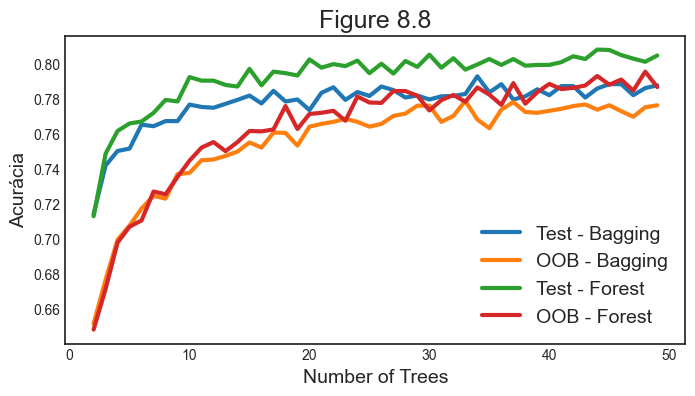

In [31]:
def make_figure_8_8():
    
    fig, ax = plt.subplots(1,1,figsize=(8,4))
    ax.set_title('Figure 8.8');

    # Plot scores
    ax.plot(params, bagging_scores);
    ax.plot(params, forest_scores);
    ax.legend(['Test - Bagging','OOB - Bagging', 'Test - Forest','OOB - Forest']);
    ax.set_xlabel('Number of Trees'); ax.set_ylabel('Acurácia');

make_figure_8_8()

Vamos comparar a importância considerada para cada recurso/variável em cada método.

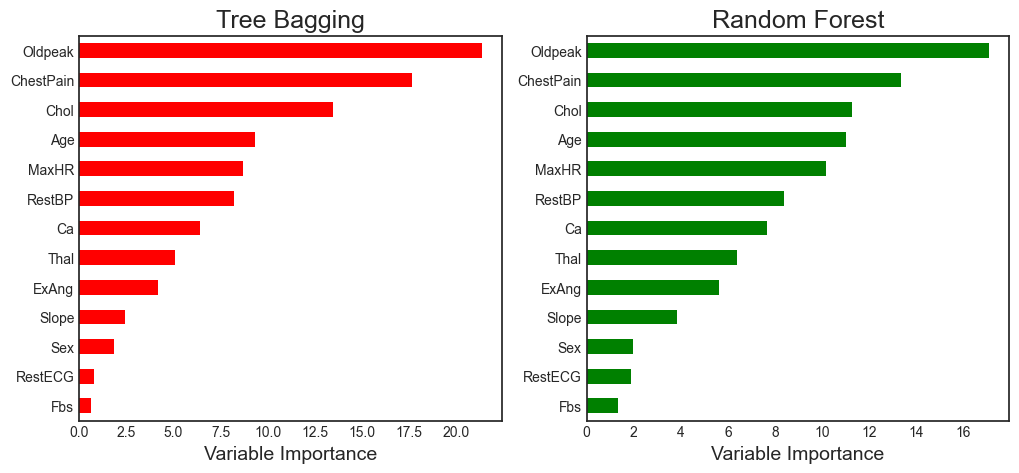

In [30]:
def make_new_figure_2():
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

    # Plot feature importance - Bagging
    h1 = pd.DataFrame({'Importance':feature_importances*100}, index=features)
    h1 = h1.sort_values(by='Importance', axis=0, ascending=True)
    h1.plot(kind='barh', color='r', ax=ax1)
    ax1.set_xlabel('Variable Importance'); 
    ax1.set_title('Tree Bagging')

    # Plot feature importance
    h2 = pd.DataFrame({'Importance':forest.feature_importances_*100}, index=features)
    h2 = h2.sort_values(by='Importance', axis=0, ascending=True)
    h2.plot(kind='barh', color='green', ax=ax2)
    ax2.set_title('Random Forest')

    # All plots
    for ax in fig.axes:
        ax.set_xlabel('Variable Importance'); 
        ax.legend([])

make_new_figure_2()

Na figura, observamos que a classificação de importância das variáveis ​​é semelhante à do *Bagging* e das Florestas Aleatórias, mas há diferenças em termos de magnitude.

### 3.3. Boosting

***Boosting*** é um algoritmo de aprendizado *ensemble*, em que:
* Modelos são treinados ***sequencialmente***, cada um tentando corrigir os erros do anterior.
* O foco é ***reduzir o viés do modelo***, aumentando progressivamente sua complexidade.
* Os exemplos mal classificados ganham mais peso nas próximas iterações.
* A combinação final é uma soma ponderada desses modelos.
* Ele pode ser aplicado tanto a problemas de **regressão** quanto de **classificação**, com adaptações na função de perda.

A Figura ilustra a lógica do algoritmo:

<div style="text-align:center;">
    <img src="images\alg_boosting.png"  alt="Imagem" style="width: 650px;"/>
</div>

- Cada nova árvore é treinada sobre os **resíduos** (erros) do modelo anterior;
- O modelo é atualizado de forma **aditiva** com uma versão suavizada da nova árvore;
- O processo se repete até alcançar o número de iterações desejado.



***Exemplo numérico:***

Queremos prever o vetor resposta:

$$
y = [10,\ 8,\ 6]
$$

***Passo 1: Inicialização***

Começamos com:

$$
\hat{f}^{(0)}(x) = 0 
$$

ou uma constante média, dependendo da implementação. Logo os **resíduos iniciais** serão:

$$
r_i = y_i - \hat{f}^{(0)}(x_i) = y_i - 0 = y_i = [10, 8, 6]
$$

***Passo 2: Treinar a primeira árvore para prever os resíduos***

A árvore 1 é treinada com:
- ***inputs:*** $X$
- ***target:*** $r = [10, 8, 6]$

Suponha que ela aprenda a função (resultado da árvore):

$$
\hat{f}^{(1)}(x) = [7, 6, 5]
$$


A ideia é que o *Gradient Boosting* usa apenas uma parte dela para ***atualizar a predição do modelo***. Ou seja, essa atualização parcial é feita com uma ***taxa de aprendizado $\lambda$*** (por exemplo, $\lambda = 0.1$ - também chamada de *learning rate*), e tem a forma:

$$
\hat{f}^{(1)}_{\text{total}}(x) = \hat{f}^{(0)}(x) + \lambda \cdot \hat{f}^{(1)}(x) = 0 + 0.1 \cdot [7,6,5] = [0.7,\ 0.6,\ 0.5]
$$

E ***atualizamos os resíduos***:

$$
r^{(1)} = y - \hat{f}^{(1)}_{\text{total}}(x) = [10,\ 8,\ 6] - [0.7,\ 0.6,\ 0.5] = [9.3,\ 7.4,\ 5.5]
$$

***Passo 3: A próxima árvore é treinada aprender sobre os novos resíduos***

A árvore 2 tenta prever os **erros que a árvore anterior cometeu**, ou seja, ela é treinada sobre $r^{(1)} = [9.3,\ 7.4,\ 5.5]$.
* ***imput***: $X$
* ***target***: $r^{(1)} = [9.3,\ 7.4,\ 5.5]$

Suponha que ela aprenda a função:

$$
\hat{f}^{(2)}(x) = [5, 4, 3]
$$
Agora, atualizamos novamente a predição do modelo:
$$
\hat{f}^{(2)}_{\text{total}}(x) = \hat{f}^{(1)}_{\text{total}}(x) + \lambda \cdot \hat{f}^{(2)}(x) = [0.7,\ 0.6,\ 0.5] + 0.1 \cdot [5,4,3] = [1.2,\ 1.0,\ 0.8]
$$
E atualizamos os resíduos novamente:
$$
r^{(2)} = y - \hat{f}^{(2)}_{\text{total}}(x) = [10,\ 8,\ 6] - [1.2,\ 1.0,\ 0.8] = [8.8,\ 7.0,\ 5.2]
$$


Esse processo continua até somarmos $B$ árvores. Essa soma ponderada de árvores é o modelo final de Boosting:
$$
\hat{f}(x) = \sum_{b=1}^{B} \lambda \cdot \hat{f}^{(b)}(x)
$$

onde cada $\hat{f}^{(b)}(x)$ é a predição da $b$-ésima árvore treinada sobre os resíduos atualizados. E o lambda $\lambda$ controla o quanto cada árvore contribui para a predição final. Esse lambda é esco


É possivel perceber que há uma conexão com a teoria de otimização: ***Gradiente Descendente***

No ***Gradient Boosting***:

- Cada nova árvore $\hat{f}^{(b)}(x)$ é treinada para prever a **direção do maior ganho de melhoria na função de perda**, ou seja, **o gradiente negativo da perda** com relação às predições anteriores.
- No caso de **erro quadrático médio (MSE)**:
  $$
  L(y, \hat{f}(x)) = \frac{1}{2}(y - \hat{f}(x))^2
  $$
  O gradiente negativo é:
  $$
  -\frac{\partial L}{\partial \hat{f}(x)} = y - \hat{f}(x) = \text{resíduo}
  $$

Ou seja, **com MSE, Boosting se reduz exatamente ao algoritmo que ajusta sucessivamente os resíduos**.

Resumo:

> A contribuição de cada nova árvore no Boosting é direcionada para **corrigir os erros residuais** das predições anteriores. Isso é feito treinando a nova árvore sobre os **resíduos atualizados**, que são exatamente o **gradiente negativo da função de perda**. No caso da regressão com MSE, isso significa treinar cada árvore sobre a diferença $y - \hat{f}(x)$. Assim, cada etapa caminha na direção da melhoria do modelo, reduzindo o erro iterativamente.

***Aplicando Boosting***

In [32]:
np.random.seed(42)

# Array para armazenar os scores
gb_scores = np.zeros(len(params))

# Loop sobre o número de árvores
for i, k in enumerate(params):
    print("Computing k=%1.0f for Gradient Boosting" % k, end="")
    
    temp_scores = np.zeros(J)
    for j in range(J):
        X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.5, random_state=j)
        
        gb = GradientBoostingClassifier(n_estimators=k, max_features="sqrt")  # opcional ajustar max_features
        gb.fit(X2_train, y2_train)
        
        temp_scores[j] = gb.score(X2_test, y2_test)  # Apenas score em teste
        
    gb_scores[i] = np.mean(temp_scores)
    print("", end="\r")

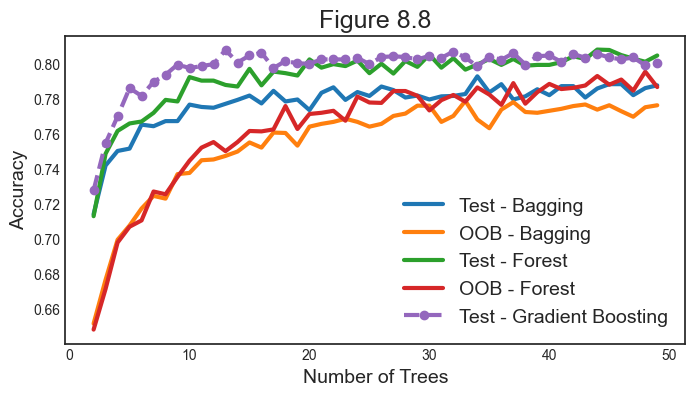

In [33]:
def make_figure_X():

    fig, ax = plt.subplots(1,1,figsize=(8,4))
    ax.set_title('Figure 8.8');

    # Plot scores
    ax.plot(params, bagging_scores[:,0])  # Test - Bagging
    ax.plot(params, bagging_scores[:,1])  # OOB - Bagging
    ax.plot(params, forest_scores[:,0])   # Test - Forest
    ax.plot(params, forest_scores[:,1])   # OOB - Forest
    ax.plot(params, gb_scores, linestyle='--', marker='o')  # Gradient Boosting - Test

    # Labels and legend
    ax.legend(['Test - Bagging', 'OOB - Bagging', 'Test - Forest', 'OOB - Forest', 'Test - Gradient Boosting']);
    ax.set_xlabel('Number of Trees')
    ax.set_ylabel('Accuracy')

make_figure_X()

In [34]:
np.random.seed(42)
gb = GradientBoostingClassifier(n_estimators=50, max_features='sqrt', random_state=42)
gb.fit(X2, y2)

GradientBoostingClassifier(max_features='sqrt', n_estimators=50,
                           random_state=42)

`n_estimators` no Gradient Boosting é o número total de árvores fracas (weak learners) que o modelo vai somar sequencialmente, cada uma corrigindo os erros da anterior. O ideal é usar validação cruzada para encontrar o número ótimo de árvores.

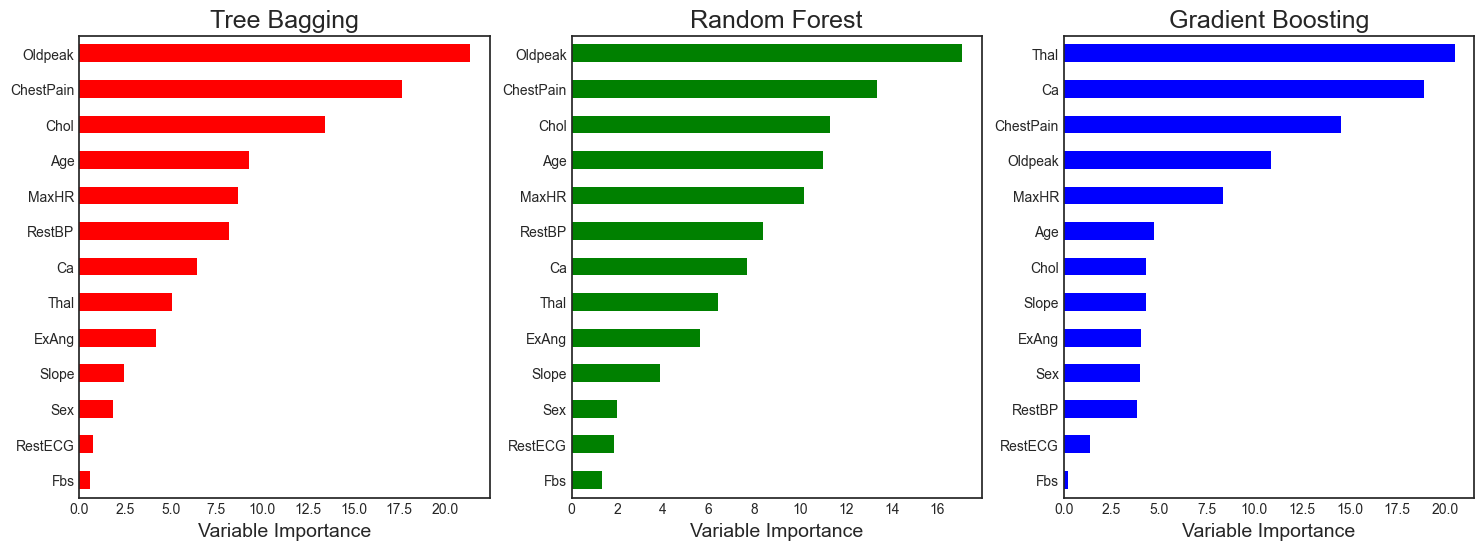

In [35]:
def make_new_figure_2():
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Bagging - Média da importância das árvores individuais
    h1 = pd.DataFrame({'Importance': feature_importances * 100}, index=features)
    h1 = h1.sort_values(by='Importance', ascending=True)
    h1.plot(kind='barh', color='red', ax=ax1)
    ax1.set_title('Tree Bagging')
    ax1.set_xlabel('Variable Importance')

    # Random Forest
    h2 = pd.DataFrame({'Importance': forest.feature_importances_ * 100}, index=features)
    h2 = h2.sort_values(by='Importance', ascending=True)
    h2.plot(kind='barh', color='green', ax=ax2)
    ax2.set_title('Random Forest')
    ax2.set_xlabel('Variable Importance')

    # Gradient Boosting
    h3 = pd.DataFrame({'Importance': gb.feature_importances_ * 100}, index=features)
    h3 = h3.sort_values(by='Importance', ascending=True)
    h3.plot(kind='barh', color='blue', ax=ax3)
    ax3.set_title('Gradient Boosting')
    ax3.set_xlabel('Variable Importance')

    # Ajustes finais
    for ax in fig.axes:
        ax.legend([])

make_new_figure_2()

### 4. Aplicações de ML em *Python*

Vamos aplicar os métodos de Machine Learning aprendidos nessa aula: Random Forests, Boosting e Bagging à dois conjuntos de dados
* `Hitter`
* `Heart` 

No primeiro utilizaremos os métodos com foco em regressão, e no segundo em classificação.

Abaixo, tento criar uma rotina que possa ser aplicada a qualquer conjunto de dados, desde que os dados estejam no formato adequado (com variáveis numéricas e categóricas devidamente tratadas). Além disso, pretendo criar uma função para testar diferentes tamanhos de árvores, número de folhas para encontrar o melhor modelo.


***Aplicação para Regressão***

Dividir os dados em treino e teste:

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Grid para encontrar o melhor modelo de regressão
* Árvore de Regressão: Focar em max_depth, max_leaf_nodes, e min_samples_leaf.
  * `max_leaf_nodes` (número máximo de folhas da árvore) entre 2 e 10.
  * `max_depth` (profundidade máxima da árvore) entre 2 e 10.
  * `min_samples_leaf`

* Random Forest / Bagging
  * n_estimators
  * max_features

* Boosting
  * learning_rate
  * n_estimators
  * subsample

Grid simultâneo para `max_leaf_nodes` e `max_depth`

Grid Search com CV no treino + avaliação final no teste

Exemplo de uso completo: Split Treino/Teste + Grid + Teste Final

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    make_scorer, mean_squared_error, mean_absolute_error,
    median_absolute_error, r2_score
)
from sklearn.inspection import permutation_importance
from scipy.stats import friedmanchisquare
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import shap

import os
import random

np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'

In [17]:
# --------------------
# Definindo features
# --------------------
features = ['Years', 'Hits', 'RBI', 'PutOuts', 'Walks', 'Runs', 'AtBat', 'HmRun']

# --------------------
# Carregando os dados
# --------------------
X_train = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Hitters_X_train.csv').dropna()[features]

In [18]:
X_test = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Hitters_X_test.csv').dropna()[features]

In [20]:
y_train = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Hitters_y_train.csv').dropna()['x']

In [22]:
y_test = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Hitters_y_test.csv').dropna()['x']

In [ ]:
# -----------------------
# Função para configurar cada modelo + Grid
# -----------------------
def get_model_and_param_grid(model_type, random_state=42):
    if model_type == 'tree':
        model = DecisionTreeRegressor(random_state=random_state)
        param_grid = {
            'model__max_depth': [3, 5, 10, 20, None],
            'model__max_leaf_nodes': [10, 20, 50, 100, None],
            'model__min_samples_leaf': [1, 5, 10, 20]
        }
    elif model_type == 'bagging':
        base_tree = DecisionTreeRegressor(random_state=random_state)
        model = BaggingRegressor(estimator=base_tree, random_state=random_state)
        param_grid = {
            'model__estimator__max_depth': [3, 5, 10, None],
            'model__estimator__max_leaf_nodes': [10, 20, 50, None],
            'model__n_estimators': [100, 300, 500, 1000]
        }
    elif model_type == 'rf':
        model = RandomForestRegressor(random_state=random_state)
        param_grid = {
            'model__max_depth': [5, 10, 20, None],
            'model__max_leaf_nodes': [10, 20, 50, 100, None],
            'model__max_features': ['sqrt', 'log2', 0.8],
            'model__n_estimators': [100, 300, 500, 1000]
        }
    elif model_type == 'gb':
        model = GradientBoostingRegressor(random_state=random_state)
        param_grid = {
            'model__max_depth': [3, 5, 10],
            'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'model__n_estimators': [100, 300, 500],
            'model__min_samples_leaf': [1, 5, 10]
        }
    elif model_type == 'xgb':
        model = XGBRegressor(random_state=random_state, verbosity=0)
        param_grid = {
            'model__max_depth': [3, 5, 10],
            'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'model__n_estimators': [100, 300, 500],
            'model__subsample': [0.6, 0.8, 1]
        }
    elif model_type == 'lgb':
        model = LGBMRegressor(force_row_wise=True, random_state=random_state, verbose=-1)
        param_grid = {
            'model__max_depth': [3, 5, 10],
            'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'model__n_estimators': [100, 300, 500],
            'model__num_leaves': [15, 31, 63, 127],
            'model__subsample': [0.6, 0.8, 1]
        }
    elif model_type == 'cat':
        model = CatBoostRegressor(random_state=random_state, verbose=0)
        param_grid = {
            'model__depth': [3, 5, 10],
            'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'model__iterations': [100, 300, 500]
        }
    elif model_type == 'ada':
        model = AdaBoostRegressor(random_state=random_state)
        param_grid = {
            'model__n_estimators': [100, 300, 500],
            'model__learning_rate': [0.01, 0.05, 0.1, 0.2]
        }
    else:
        raise ValueError(f"Modelo '{model_type}' não reconhecido.")
    
    return model, param_grid

# -----------------------
# Nested CV + Importância + Overfit Gap
# -----------------------
def nested_cv_with_importance(X, y, model_type, feature_names, cv_outer=5, cv_inner=3, random_state=42):
    model, param_grid = get_model_and_param_grid(model_type, random_state=random_state)
    pipeline = Pipeline([('model', model)])
    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    outer_cv = KFold(n_splits=cv_outer, shuffle=True, random_state=random_state)
    inner_cv = KFold(n_splits=cv_inner, shuffle=True, random_state=random_state)

    outer_mse, outer_r2, outer_mae, inner_mse = [], [], [], []
    permutation_importances_folds = []
    feature_importance_folds = []
    best_params_list = []
    fold_level_results = []  # <<< NOVO: Guardar resultados por fold

    exec_start = time.time()

    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X)):
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grid = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring=scorer, n_jobs=-1)
            grid.fit(X_train_fold, y_train_fold)

        best_model = grid.best_estimator_
        best_params_list.append(grid.best_params_)
        inner_mse.append(-grid.best_score_)

        y_pred = best_model.predict(X_test_fold)
        fold_mse = mean_squared_error(y_test_fold, y_pred)
        fold_r2 = r2_score(y_test_fold, y_pred)
        fold_mae = mean_absolute_error(y_test_fold, y_pred)

        outer_mse.append(fold_mse)
        outer_r2.append(fold_r2)
        outer_mae.append(fold_mae)

        # Permutation Importance por fold
        perm = permutation_importance(best_model, X_test_fold, y_test_fold, n_repeats=10, random_state=random_state, scoring='neg_mean_squared_error')
        permutation_importances_folds.append(perm.importances_mean)

        # Feature Importance tradicional por fold
        try:
            fi = best_model.named_steps['model'].feature_importances_
        except:
            fi = np.full(len(feature_names), np.nan)
        feature_importance_folds.append(fi)

        # Guardar tudo fold-a-fold
        fold_result = {
            'Model': model_type.upper(),
            'Fold': fold_idx + 1,
            'MSE': fold_mse,
            'R2': fold_r2,
            'MAE': fold_mae,
            'Best_Params': grid.best_params_,
            'Perm_Importance': perm.importances_mean.tolist(),
            'Feature_Importance': fi.tolist()
        }
        fold_level_results.append(fold_result)

    exec_time = time.time() - exec_start
    overfit_gap = np.mean(inner_mse) - np.mean(outer_mse)

    # Métricas agregadas
    perm_mean = np.nanmean(permutation_importances_folds, axis=0)
    perm_std = np.nanstd(permutation_importances_folds, axis=0)
    traditional_mean = np.nanmean(feature_importance_folds, axis=0)
    traditional_std = np.nanstd(feature_importance_folds, axis=0)

    result = {
        'Model': model_type.upper(),
        'Inner_CV_MSE_Mean': np.mean(inner_mse),
        'Outer_Test_MSE_Mean': np.mean(outer_mse),
        'Outer_Test_MSE_Std': np.std(outer_mse),
        'Outer_Test_R2_Mean': np.mean(outer_r2),
        'Outer_Test_MAE_Mean': np.mean(outer_mae),
        'Overfit_Gap': overfit_gap,
        'Exec_Time_Seconds': exec_time,
        'Best_Params_Per_Fold': best_params_list,
        'Perm_Importance_Mean': perm_mean.tolist(),
        'Perm_Importance_Std': perm_std.tolist(),
        'Feature_Importance_Mean': traditional_mean.tolist(),
        'Feature_Importance_Std': traditional_std.tolist(),
        'Outer_MSE_Folds': outer_mse,  # Para Friedman
        'Fold_Level_Results': fold_level_results  # <<< NOVO: Detalhado por fold
    }

    return result

In [24]:
# -----------------------
# Execução Nested CV
# -----------------------
feature_names = X_train.columns.tolist()
model_types = ['tree', 'bagging', 'rf', 'gb', 'xgb', 'lgb', 'cat', 'ada']
final_results = []
mse_distributions = []

for model_type in model_types:
    print(f"\nNested CV: {model_type.upper()}")
    result = nested_cv_with_importance(X_train, y_train.squeeze(), model_type, feature_names)
    final_results.append(result)
    mse_distributions.append(result['Outer_MSE_Folds'])

results_df = pd.DataFrame(final_results)


Nested CV: TREE

Nested CV: BAGGING


Mean of empty slice
Degrees of freedom <= 0 for slice.



Nested CV: RF

Nested CV: GB

Nested CV: XGB

Nested CV: LGB

Nested CV: CAT

Nested CV: ADA


In [25]:
print(results_df.to_markdown(index=False))

| Model   |   Inner_CV_MSE_Mean |   Outer_Test_MSE_Mean |   Outer_Test_MSE_Std |   Outer_Test_R2_Mean |   Outer_Test_MAE_Mean |   Overfit_Gap |   Exec_Time_Seconds | Best_Params_Per_Fold                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | Perm_Importance_Mean                                                                                                                                            | Perm

In [26]:
# Concatenar todos os resultados fold-a-fold
all_folds = []
for res in final_results:
    all_folds.extend(res['Fold_Level_Results'])

# Criar DataFrame
folds_df = pd.DataFrame(all_folds)

In [27]:
# -----------------------
# Friedman Test
# -----------------------
mse_array = np.array(mse_distributions).T
friedman_stat, p_value = friedmanchisquare(*[mse_array[:, i] for i in range(mse_array.shape[1])])

print("\n==== Friedman Test ====")
print(f"Chi-square: {friedman_stat:.4f}, p-value: {p_value:.4f}")


==== Friedman Test ====
Chi-square: 9.4667, p-value: 0.2209


In [28]:
# -----------------------
# Nemenyi Test
# -----------------------
import scikit_posthocs as sp
import seaborn as sns

# Transforma o array das MSEs fold-a-fold em um DataFrame
mse_df = pd.DataFrame(mse_array, columns=[m.upper() for m in model_types])

# Teste de Nemenyi
nemenyi_result = sp.posthoc_nemenyi_friedman(mse_df.values)

print("\n==== Nemenyi Post-Hoc Test (p-values) ====")
print(pd.DataFrame(nemenyi_result, index=mse_df.columns, columns=mse_df.columns).round(4))

# Heatmap das diferenças
plt.figure(figsize=(8,6))
sns.heatmap(nemenyi_result, xticklabels=mse_df.columns, yticklabels=mse_df.columns, annot=True, fmt=".3f", cmap="coolwarm")
plt.title("Nemenyi Post-Hoc Test (p-values)")
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'scikit_posthocs'


>>> Melhor Modelo Final: CAT


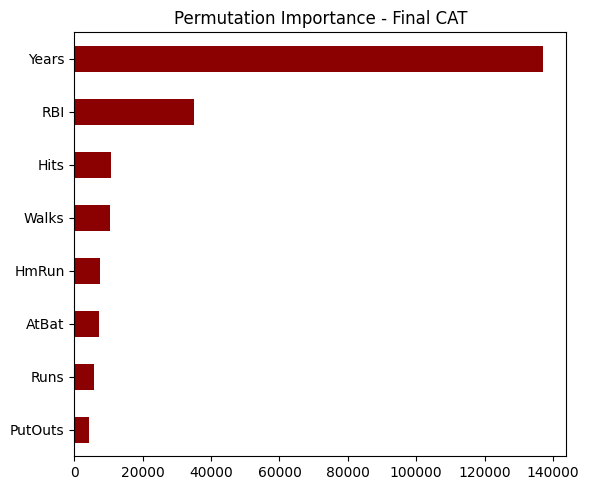

SHAP não suportado para CAT: 'TreeEnsemble' object has no attribute 'values'


In [29]:
# -----------------------
# Melhor Modelo: Refit + Permutation Final + SHAP + Feature Importance Plot
# -----------------------
best_model_idx = results_df['Outer_Test_MSE_Mean'].idxmin()
best_model_name = results_df.loc[best_model_idx, 'Model']

print(f"\n>>> Melhor Modelo Final: {best_model_name}")

# Refit final
final_model, final_param_grid = get_model_and_param_grid(best_model_name.lower(), random_state=42)
pipeline_final = Pipeline([('model', final_model)])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    grid_final = GridSearchCV(pipeline_final, final_param_grid, cv=5, scoring=make_scorer(mean_squared_error, greater_is_better=False), n_jobs=-1)
    grid_final.fit(X_train, y_train.squeeze())

final_best_model = grid_final.best_estimator_

# Permutation Importance Final
perm_final = permutation_importance(final_best_model, X_train, y_train.squeeze(), n_repeats=10, random_state=42, scoring='neg_mean_squared_error')
perm_importance_final = pd.Series(perm_final.importances_mean, index=feature_names).sort_values(ascending=True)

plt.figure(figsize=(6,5))
perm_importance_final.plot(kind='barh', color='darkred')
plt.title(f'Permutation Importance - Final {best_model_name}')
plt.tight_layout()
plt.show()

# SHAP Final
try:
    explainer = shap.Explainer(final_best_model.named_steps['model'], X_train)
    shap_values = explainer(X_train)
    shap.summary_plot(shap_values, X_train, show=False)
    plt.savefig(f"shap_summary_final_{best_model_name}.png", dpi=300, bbox_inches='tight')
    plt.close()
except Exception as e:
    print(f"SHAP não suportado para {best_model_name}: {e}")



===== Performance FINAL no Test Set usando XGB =====
Test MSE   : 160592.7218
Test RMSE  : 400.7402
Test R²    : 0.2446
Test MAE   : 247.6928
Test MedAE : 148.0202


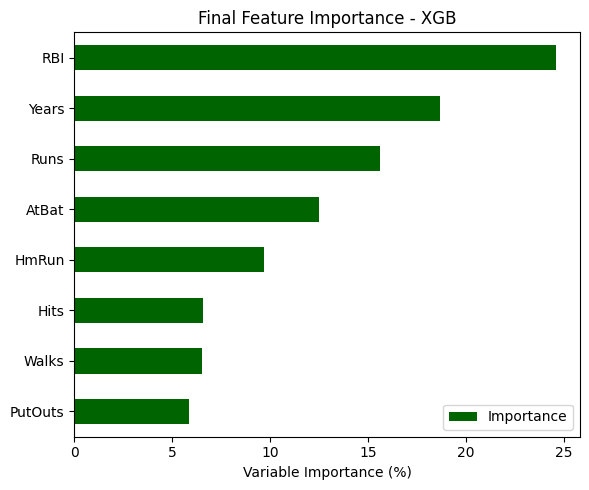

[07:43:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


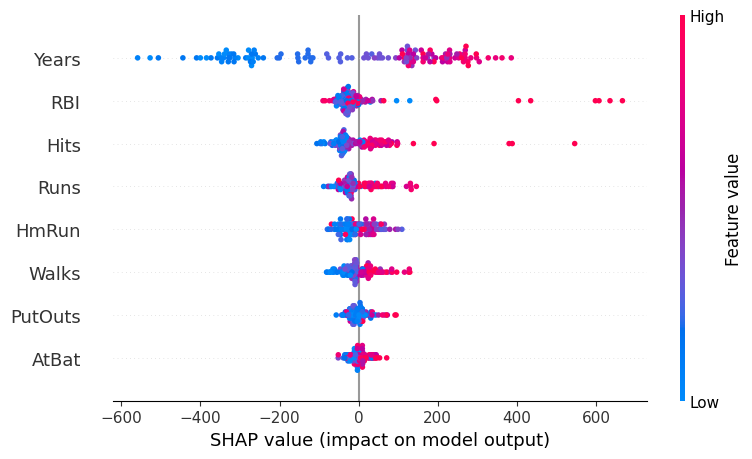

In [ ]:
# ==================================================
# Verificando em outo modelo: XGB para o Refit Final
# ==================================================

# Define manualmente o modelo que deseja verificar
forced_model_name = 'XGB'

# Recupera o primeiro conjunto de hiperparâmetros encontrados para o XGB nos folds
xgb_idx = results_df[results_df['Model'] == forced_model_name].index[0]
best_params = results_df.loc[xgb_idx, 'Best_Params_Per_Fold'][0]

# Recria o modelo base + pipeline
model, _ = get_model_and_param_grid(forced_model_name.lower())
pipeline = Pipeline([('model', model)])

# Ajusta os hiperparâmetros (removendo o prefixo model__)
clean_best_params = {k.replace('model__', ''): v for k, v in best_params.items()}
pipeline.set_params(**{f'model__{k}': v for k, v in clean_best_params.items()})

# Refit no conjunto de treino completo
pipeline.fit(X_train, y_train.squeeze())

# Predição no Test Set
y_test_pred = pipeline.predict(X_test)

# Avaliação
final_mse = mean_squared_error(y_test, y_test_pred)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_test, y_test_pred)
final_mae = mean_absolute_error(y_test, y_test_pred)
final_medae = median_absolute_error(y_test, y_test_pred)

print(f"\n===== Performance FINAL no Test Set usando XGB =====")
print(f"Test MSE   : {final_mse:.4f}")
print(f"Test RMSE  : {final_rmse:.4f}")
print(f"Test R²    : {final_r2:.4f}")
print(f"Test MAE   : {final_mae:.4f}")
print(f"Test MedAE : {final_medae:.4f}")

# ==============================================
# Feature Importance Tradicional (para o XGB)
# ==============================================

try:
    feature_importances = pipeline.named_steps['model'].feature_importances_
    plt.figure(figsize=(6, 5))
    h1 = pd.DataFrame({'Importance': feature_importances * 100}, index=X_train.columns)
    h1 = h1.sort_values(by='Importance', ascending=True)
    h1.plot(kind='barh', color='darkgreen', ax=plt.gca())
    plt.title('Final Feature Importance - XGB')
    plt.xlabel('Variable Importance (%)')
    plt.tight_layout()
    plt.show()
except:
    print("O modelo XGB não possui atributo 'feature_importances_'.")

# ==============================================
# SHAP Values (se suportado pelo XGB)
# ==============================================

try:
    explainer = shap.Explainer(pipeline.named_steps['model'], X_train)
    shap_values = explainer(X_train)
    shap.summary_plot(shap_values, X_train)
except Exception as e:
    print(f"SHAP não pôde ser calculado para o XGB. Motivo: {e}")


A Figura apresenta o summary plot dos valores SHAP gerados a partir do modelo final de previsão de salários utilizando o algoritmo XGBoost, treinado com os melhores hiperparâmetros encontrados via Nested Cross-Validation. Essa análise permite quantificar o impacto marginal de cada variável preditora sobre as previsões individuais, além de fornecer insights sobre a direção e a magnitude dos efeitos.

Principais Resultados:

* Relevância Relativa das Variáveis:
  * A variável Years (anos de experiência) se destaca como a preditora mais relevante para explicar o salário dos jogadores. 
  * As variáveis RBI, Hits, e Runs também apresentaram impactos significativos sobre a previsão do salário, refletindo o papel da performance ofensiva como determinante da remuneração no beisebol profissional.

* Direcionalidade dos Efeitos:
  * Observa-se que valores altos de Years (em rosa) estão fortemente associados a impactos positivos no salário previsto, enquanto valores baixos de Years (em azul) estão associados a impactos negativos.
  * Isso indica uma relação positiva entre experiência e salário, conforme esperado.
  * No caso de RBI e Hits, uma tendência similar é observada: maiores valores dessas variáveis aumentam a previsão salarial.

* Variabilidade Individual dos Efeitos:
  * A dispersão dos pontos ao longo do eixo X revela que o efeito de uma mesma variável pode variar substancialmente entre os indivíduos da amostra.
  * Por exemplo, Years apresenta uma ampla gama de valores SHAP, indicando que, mesmo controlando para os demais preditores, o impacto marginal da experiência pode variar bastante dependendo do perfil do jogador.

* Interpretação de Não-Linearidades e Interações:
  * A distribuição não simétrica e a sobreposição de cores nas variáveis indicam a presença de não-linearidades e interações complexas entre os preditores, fenômenos que o modelo XGBoost captura naturalmente.

* Contribuição para a Análise Preditiva:
  * A utilização dos SHAP Values fortalece a interpretação do modelo ao fornecer explicabilidade local e global, permitindo ao pesquisador compreender como cada variável contribui para a variação individual nas previsões salariais. Este tipo de análise é particularmente relevante quando o objetivo inclui, além da acurácia preditiva, a interpretação econômica dos determinantes salariais.

In [138]:
# ==============================================
# Teste de Friedman + Nemenyi Test
# Comparação estatística entre os modelos
# ==============================================

import numpy as np
import pandas as pd
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns

# Organizando os Outer MSE de cada modelo (que você já salvou fold a fold)
# Cada coluna = um modelo, cada linha = um fold externo
mse_array = np.array([result['Outer_MSE_Folds'] for result in final_results]).T
model_names = [result['Model'] for result in final_results]

# ---------- Friedman Test ----------
friedman_stat, p_value = friedmanchisquare(*[mse_array[:, i] for i in range(mse_array.shape[1])])

print("\n==== Teste de Friedman ====")
print(f"Chi-square: {friedman_stat:.4f}, p-value: {p_value:.4f}")

# ---------- Nemenyi Post-hoc ----------
if p_value < 0.05:
    print("\nComo p < 0.05, realizando Nemenyi Test (comparações par-a-par)...")
    nemenyi_result = sp.posthoc_nemenyi_friedman(mse_array)

    nemenyi_df = pd.DataFrame(nemenyi_result, columns=model_names, index=model_names)
    print("\nMatriz de p-values (Nemenyi Test - comparação par a par):")
    print(nemenyi_df)

    # Heatmap das diferenças par a par
    plt.figure(figsize=(8, 6))
    sns.heatmap(nemenyi_df, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'p-value'})
    plt.title("Nemenyi Post-hoc Test (p-values)")
    plt.tight_layout()
    plt.show()
else:
    print("\np >= 0.05: Não há evidência estatística de diferença global entre os modelos (Friedman Test).")


ModuleNotFoundError: No module named 'scikit_posthocs'

***Interpretação dos seus resultados:***

| Modelo               | CV MSE (Treino/Validação Interna) | Test MSE (Generalização) | Observações |
|----------------------|-----------------------------------|--------------------------|-------------|
| ADA                  | 0.294                             | 0.304                    | Melhor desempenho geral no Teste. Indica boa capacidade de generalização no seu caso específico. |
| XGB                  | 0.293                             | 0.306                    | Muito próximo do AdaBoost. Consistente entre CV e Teste. |
| Bagging              | 0.279                             | 0.320                    | Ótimo desempenho no CV, mas um pouco de perda no Teste. Pode estar começando a overfit. |
| CatBoost             | 0.266                             | 0.320                    | Melhor CV MSE, mas Test MSE subiu bastante. Indício de overfitting leve. |
| Random Forest (RF)   | 0.281                             | 0.342                    | Sem grandes surpresas, desempenho intermediário. |
| Gradient Boosting (GB)| 0.285                            | 0.381                    | Perdeu bastante performance no Teste. Pode ter overfitado. |
| LightGBM (LGB)       | 0.278                             | 0.393                    | Parecido com o GB e RF, um pouco mais de overfitting. |
| Tree Simples         | 0.321                             | 0.417                    | Pior performance geral, como esperado para uma árvore individual simples. |


**Critério de Escolha do Melhor Modelo:**

A escolha final do modelo deve ser feita com base no desempenho no conjunto de teste (Test MSE), pois ele reflete a capacidade real de generalização. 

A Validação Cruzada (CV MSE) deve ser usada apenas durante o ajuste dos hiperparâmetros para evitar overfitting ao conjunto de treino.

**Regra de decisão final:**  
Escolha o modelo com o menor Test MSE entre todas as alternativas testadas.


***AdaBoost e XGBoost tiveram o melhor equilíbrio entre erro de validação e erro fora da amostra.***


In [41]:
# Pegando o melhor modelo
best_ada = best_models['ADA']
y_pred_ada = best_ada.predict(X_test)

"Dumbbell plot" ou "linha de erro por observação"

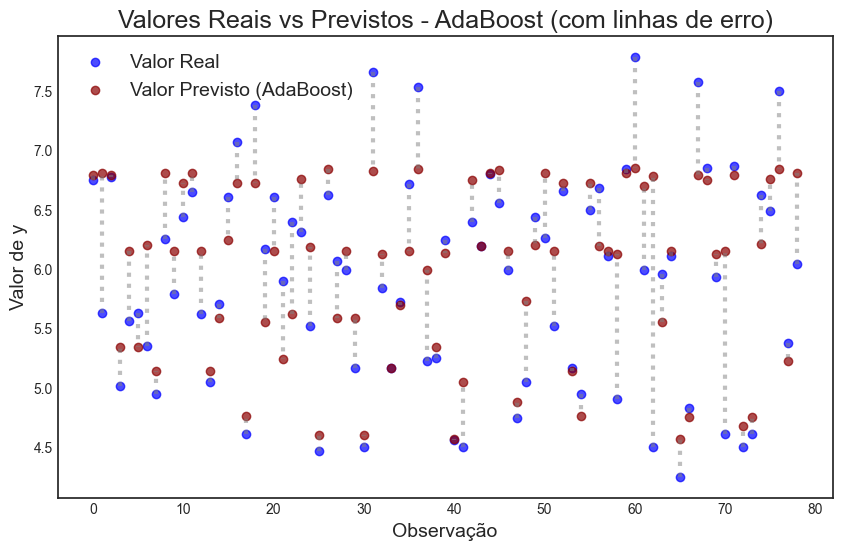

In [55]:
import matplotlib.pyplot as plt
import pandas as pd

# Garantir que ambos estão como Series e com os mesmos índices
y_real_series = pd.Series(y_test).reset_index(drop=True)
y_pred_series = pd.Series(y_pred_ada).reset_index(drop=True)
x_values = range(len(y_real_series))

plt.figure(figsize=(10, 6))

# Linhas pontilhadas conectando cada ponto real ao previsto
for i in x_values:
    plt.plot([i, i], [y_real_series[i], y_pred_series[i]], color='gray', linestyle='dotted', alpha=0.5)

# Pontos reais (Azul escuro)
plt.scatter(x_values, y_real_series, color='blue', label='Valor Real', alpha=0.7)

# Pontos previstos (Vermelho escuro)
plt.scatter(x_values, y_pred_series, color='darkred', label='Valor Previsto (AdaBoost)', alpha=0.7)

plt.xlabel('Observação')
plt.ylabel('Valor de y')
plt.title('Valores Reais vs Previstos - AdaBoost (com linhas de erro)')
plt.legend()
plt.show()

### 5. Considerações Finais

Na aula de hoje vimos como as árvores de decisão podem ser utilizadas tanto para problemas de regressão quanto de classificação, e como os métodos de ensemble, como Bagging, Random Forests e Boosting, podem melhorar significativamente o desempenho dos modelos baseados em árvores.


---

Exemplo de código com aplicação avançada.

In [ ]:
import numpy as np
import pandas as pd
import warnings
import time
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    make_scorer, mean_squared_error, mean_absolute_error,
    median_absolute_error, r2_score
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    BaggingRegressor, RandomForestRegressor,
    GradientBoostingRegressor, AdaBoostRegressor
)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# ----------------------------------------
# Função: Define modelos e grids de hiperparâmetros
# ----------------------------------------
def get_model_and_param_grid(model_type, random_state=42):
    if model_type == 'tree':
        model = DecisionTreeRegressor(random_state=random_state)
        param_grid = {
            'model__max_depth': [3, 5, 10, 20, None],
            'model__max_leaf_nodes': [10, 20, 50, 100, None],
            'model__min_samples_leaf': [1, 5, 10, 20]
        }
    elif model_type == 'bagging':
        base_tree = DecisionTreeRegressor(random_state=random_state)
        model = BaggingRegressor(estimator=base_tree, random_state=random_state)
        param_grid = {
            'model__estimator__max_depth': [3, 5, 10, None],
            'model__estimator__max_leaf_nodes': [10, 20, 50, None],
            'model__n_estimators': [100, 300, 500, 1000]
        }
    elif model_type == 'rf':
        model = RandomForestRegressor(random_state=random_state)
        param_grid = {
            'model__max_depth': [5, 10, 20, None],
            'model__max_leaf_nodes': [10, 20, 50, 100, None],
            'model__max_features': ['sqrt', 'log2', 0.8],
            'model__n_estimators': [100, 300, 500, 1000]
        }
    elif model_type == 'gb':
        model = GradientBoostingRegressor(random_state=random_state)
        param_grid = {
            'model__max_depth': [3, 5, 10],
            'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'model__n_estimators': [100, 300, 500],
            'model__min_samples_leaf': [1, 5, 10]
        }
    elif model_type == 'xgb':
        model = XGBRegressor(random_state=random_state, verbosity=0)
        param_grid = {
            'model__max_depth': [3, 5, 10],
            'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'model__n_estimators': [100, 300, 500],
            'model__subsample': [0.6, 0.8, 1]
        }
    elif model_type == 'lgb':
        model = LGBMRegressor(force_row_wise=True, random_state=random_state, verbose=-1)
        param_grid = {
            'model__max_depth': [3, 5, 10],
            'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'model__n_estimators': [100, 300, 500],
            'model__num_leaves': [15, 31, 63, 127],
            'model__subsample': [0.6, 0.8, 1]
        }
    elif model_type == 'cat':
        model = CatBoostRegressor(random_state=random_state, verbose=0)
        param_grid = {
            'model__depth': [3, 5, 10],
            'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'model__iterations': [100, 300, 500]
        }
    elif model_type == 'ada':
        model = AdaBoostRegressor(random_state=random_state)
        param_grid = {
            'model__n_estimators': [100, 300, 500],
            'model__learning_rate': [0.01, 0.05, 0.1, 0.2]
        }
    else:
        raise ValueError(f"Modelo '{model_type}' não reconhecido.")
    
    return model, param_grid

# ----------------------------------------
# Função: Nested Cross-Validation com cálculo de overfitting gap
# ----------------------------------------
def nested_cv_search(X, y, model_type, cv_outer=5, cv_inner=3, random_state=42):
    model, param_grid = get_model_and_param_grid(model_type, random_state=random_state)
    pipeline = Pipeline([('model', model)])
    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    outer_cv = KFold(n_splits=cv_outer, shuffle=True, random_state=random_state)
    inner_cv = KFold(n_splits=cv_inner, shuffle=True, random_state=random_state)

    outer_mse, outer_rmse, outer_mae, outer_med_ae, outer_r2, inner_cv_mse_list, best_params_list = [], [], [], [], [], [], []
    start_time = time.time()

    for train_idx, test_idx in outer_cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grid = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring=scorer, n_jobs=-1)
            grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        best_params_list.append(grid.best_params_)
        y_pred = best_model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        med_ae = median_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        outer_mse.append(mse)
        outer_rmse.append(rmse)
        outer_mae.append(mae)
        outer_med_ae.append(med_ae)
        outer_r2.append(r2)
        inner_cv_mse_list.append(-grid.best_score_)

    exec_time = time.time() - start_time
    overfit_gap = np.mean(inner_cv_mse_list) - np.mean(outer_mse)

    result = {
        'Model': model_type.upper(),
        'Inner_CV_MSE_Mean': np.mean(inner_cv_mse_list),
        'Inner_CV_RMSE_Mean': np.sqrt(np.mean(inner_cv_mse_list)),
        'Outer_Test_MSE_Mean': np.mean(outer_mse),
        'Outer_Test_RMSE_Mean': np.mean(outer_rmse),
        'Outer_Test_MSE_Std': np.std(outer_mse),
        'Outer_Test_MAE_Mean': np.mean(outer_mae),
        'Outer_Test_MedAE_Mean': np.mean(outer_med_ae),
        'Outer_Test_R2_Mean': np.mean(outer_r2),
        'Overfit_Gap': overfit_gap,
        'Exec_Time_Seconds': exec_time,
        'Best_Params_Per_Fold': best_params_list
    }

    return result

# ----------------------------------------
# Execução Geral
# ----------------------------------------
model_types = ['tree', 'bagging', 'rf', 'gb', 'xgb', 'lgb', 'cat', 'ada']
final_results = []

for model_type in model_types:
    result = nested_cv_search(X_train, y_train, model_type, cv_outer=5, cv_inner=3, random_state=42)
    final_results.append(result)

# Resultado final
results_df = pd.DataFrame(final_results)


In [ ]:
import numpy as np
import pandas as pd
import warnings
import time
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    make_scorer, mean_squared_error, mean_absolute_error,
    median_absolute_error, r2_score
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    BaggingRegressor, RandomForestRegressor,
    GradientBoostingRegressor, AdaBoostRegressor
)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Carregando os dados
X_train = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Hitters_X_train.csv').dropna()[features]
X_test = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Hitters_X_test.csv').dropna()[features]
y_train = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Hitters_y_train.csv').dropna()
y_test = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Hitters_y_test.csv').dropna()

# definindo features
features = ['Years', 'Hits', 'RBI', 'PutOuts', 'Walks', 'Runs', 'AtBat', 'HmRun']



def get_model_and_param_grid(model_type, random_state=42):
    if model_type == 'tree':
        model = DecisionTreeRegressor(random_state=random_state)
        param_grid = {
            'model__max_depth': [3, 5, 10, 20, None],
            'model__max_leaf_nodes': [10, 20, 50, 100, None],
            'model__min_samples_leaf': [1, 5, 10, 20]
        }
    elif model_type == 'bagging':
        base_tree = DecisionTreeRegressor(random_state=random_state)
        model = BaggingRegressor(estimator=base_tree, random_state=random_state)
        param_grid = {
            'model__estimator__max_depth': [3, 5, 10, None],
            'model__estimator__max_leaf_nodes': [10, 20, 50, None],
            'model__n_estimators': [100, 300, 500, 1000]
        }
    elif model_type == 'rf':
        model = RandomForestRegressor(random_state=random_state)
        param_grid = {
            'model__max_depth': [5, 10, 20, None],
            'model__max_leaf_nodes': [10, 20, 50, 100, None],
            'model__max_features': ['sqrt', 'log2', 0.8],
            'model__n_estimators': [100, 300, 500, 1000]
        }
    elif model_type == 'gb':
        model = GradientBoostingRegressor(random_state=random_state)
        param_grid = {
            'model__max_depth': [3, 5, 10],
            'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'model__n_estimators': [100, 300, 500],
            'model__min_samples_leaf': [1, 5, 10]
        }
    elif model_type == 'xgb':
        model = XGBRegressor(random_state=random_state, verbosity=0)
        param_grid = {
            'model__max_depth': [3, 5, 10],
            'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'model__n_estimators': [100, 300, 500],
            'model__subsample': [0.6, 0.8, 1]
        }
    elif model_type == 'lgb':
        model = LGBMRegressor(force_row_wise=True, random_state=random_state, verbose=-1)
        param_grid = {
            'model__max_depth': [3, 5, 10],
            'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'model__n_estimators': [100, 300, 500],
            'model__num_leaves': [15, 31, 63, 127],
            'model__subsample': [0.6, 0.8, 1]
        }
    elif model_type == 'cat':
        model = CatBoostRegressor(random_state=random_state, verbose=0)
        param_grid = {
            'model__depth': [3, 5, 10],
            'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'model__iterations': [100, 300, 500]
        }
    elif model_type == 'ada':
        model = AdaBoostRegressor(random_state=random_state)
        param_grid = {
            'model__n_estimators': [100, 300, 500],
            'model__learning_rate': [0.01, 0.05, 0.1, 0.2]
        }
    else:
        raise ValueError(f"Modelo '{model_type}' não reconhecido.")
    
    return model, param_grid

def nested_cv_search(X, y, model_type, cv_outer=5, cv_inner=3, random_state=42):
    X = pd.DataFrame(X)
    y = pd.Series(y)

    model, param_grid = get_model_and_param_grid(model_type, random_state=random_state)
    pipeline = Pipeline([('model', model)])
    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    outer_cv = KFold(n_splits=cv_outer, shuffle=True, random_state=random_state)
    inner_cv = KFold(n_splits=cv_inner, shuffle=True, random_state=random_state)

    outer_mse, outer_rmse, outer_mae, outer_med_ae, outer_r2, inner_cv_mse_list, best_params_list = [], [], [], [], [], [], []
    start_time = time.time()

    for train_idx, test_idx in outer_cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grid = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring=scorer, n_jobs=-1)
            grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        best_params_list.append(grid.best_params_)
        y_pred = best_model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        med_ae = median_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        outer_mse.append(mse)
        outer_rmse.append(rmse)
        outer_mae.append(mae)
        outer_med_ae.append(med_ae)
        outer_r2.append(r2)
        inner_cv_mse_list.append(-grid.best_score_)

    exec_time = time.time() - start_time

    overfit_gap = np.mean(inner_cv_mse_list) - np.mean(outer_mse)

    result = {
        'Model': model_type.upper(),
        'Inner_CV_MSE_Mean': np.mean(inner_cv_mse_list),
        'Inner_CV_RMSE_Mean': np.sqrt(np.mean(inner_cv_mse_list)),
        'Outer_Test_MSE_Mean': np.mean(outer_mse),
        'Outer_Test_RMSE_Mean': np.mean(outer_rmse),
        'Outer_Test_MSE_Std': np.std(outer_mse),
        'Outer_Test_MAE_Mean': np.mean(outer_mae),
        'Outer_Test_MedAE_Mean': np.mean(outer_med_ae),
        'Outer_Test_R2_Mean': np.mean(outer_r2),
        'Overfit_Gap': overfit_gap,
        'Exec_Time_Seconds': exec_time,
        'Best_Params_Per_Fold': best_params_list
    }

    return result

# ----------------------
# Execução para o seu caso
# ----------------------

model_types = ['tree', 'bagging', 'rf', 'gb', 'xgb', 'lgb', 'cat', 'ada']
final_results = []

for model_type in model_types:
    result = nested_cv_search(X_train, y_train, model_type, cv_outer=5, cv_inner=3, random_state=42)
    final_results.append(result)

results_df = pd.DataFrame(final_results)


In [72]:
import numpy as np
import pandas as pd
import warnings
import time
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

def get_model_and_param_grid(model_type, random_state=42):
    if model_type == 'tree':
        model = DecisionTreeRegressor(random_state=random_state)
        param_grid = {
            'model__max_depth': [3, 5, 10, 20, None],
            'model__max_leaf_nodes': [10, 20, 50, 100, None],
            'model__min_samples_leaf': [1, 5, 10, 20]
        }
    elif model_type == 'bagging':
        base_tree = DecisionTreeRegressor(random_state=random_state)
        model = BaggingRegressor(estimator=base_tree, random_state=random_state)
        param_grid = {
            'model__estimator__max_depth': [3, 5, 10, None],
            'model__estimator__max_leaf_nodes': [10, 20, 50, None],
            'model__n_estimators': [100, 300, 500, 1000]
        }
    elif model_type == 'rf':
        model = RandomForestRegressor(random_state=random_state)
        param_grid = {
            'model__max_depth': [5, 10, 20, None],
            'model__max_leaf_nodes': [10, 20, 50, 100, None],
            'model__max_features': ['sqrt', 'log2', 0.8],
            'model__n_estimators': [100, 300, 500, 1000]
        }
    elif model_type == 'gb':
        model = GradientBoostingRegressor(random_state=random_state)
        param_grid = {
            'model__max_depth': [3, 5, 10],
            'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'model__n_estimators': [100, 300, 500],
            'model__min_samples_leaf': [1, 5, 10]
        }
    elif model_type == 'xgb':
        model = XGBRegressor(random_state=random_state, verbosity=0)
        param_grid = {
            'model__max_depth': [3, 5, 10],
            'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'model__n_estimators': [100, 300, 500],
            'model__subsample': [0.6, 0.8, 1]
        }
    elif model_type == 'lgb':
        model = LGBMRegressor(force_row_wise=True, random_state=random_state, verbose=-1)
        param_grid = {
            'model__max_depth': [3, 5, 10],
            'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'model__n_estimators': [100, 300, 500],
            'model__num_leaves': [15, 31, 63, 127],
            'model__subsample': [0.6, 0.8, 1]
        }
    elif model_type == 'cat':
        model = CatBoostRegressor(random_state=random_state, verbose=0)
        param_grid = {
            'model__depth': [3, 5, 10],
            'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'model__iterations': [100, 300, 500]
        }
    elif model_type == 'ada':
        model = AdaBoostRegressor(random_state=random_state)
        param_grid = {
            'model__n_estimators': [100, 300, 500],
            'model__learning_rate': [0.01, 0.05, 0.1, 0.2]
        }
    else:
        raise ValueError(f"Modelo '{model_type}' não reconhecido.")
    
    return model, param_grid

def nested_cv_search(X, y, model_type, cv_outer=5, cv_inner=3, random_state=42):
    X = pd.DataFrame(X)
    y = pd.Series(y)

    model, param_grid = get_model_and_param_grid(model_type, random_state=random_state)
    pipeline = Pipeline([('model', model)])
    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    outer_cv = KFold(n_splits=cv_outer, shuffle=True, random_state=random_state)
    inner_cv = KFold(n_splits=cv_inner, shuffle=True, random_state=random_state)

    outer_mse, outer_rmse, outer_mae, outer_med_ae, outer_r2, inner_cv_mse_list, best_params_list = [], [], [], [], [], [], []

    start_time = time.time()

    for train_idx, test_idx in outer_cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grid = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring=scorer, n_jobs=-1)
            grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        best_params_list.append(grid.best_params_)
        y_pred = best_model.predict(X_test)

        # Outer Test Metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        med_ae = median_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        outer_mse.append(mse)
        outer_rmse.append(rmse)
        outer_mae.append(mae)
        outer_med_ae.append(med_ae)
        outer_r2.append(r2)

        inner_cv_mse_list.append(-grid.best_score_)

    exec_time = time.time() - start_time

    result = {
        'Model': model_type.upper(),
        'Inner_CV_MSE_Mean': np.mean(inner_cv_mse_list),
        'Inner_CV_RMSE_Mean': np.sqrt(np.mean(inner_cv_mse_list)),
        'Outer_Test_MSE_Mean': np.mean(outer_mse),
        'Outer_Test_RMSE_Mean': np.mean(outer_rmse),
        'Outer_Test_MSE_Std': np.std(outer_mse),
        'Outer_Test_MAE_Mean': np.mean(outer_mae),
        'Outer_Test_MedAE_Mean': np.mean(outer_med_ae),
        'Outer_Test_R2_Mean': np.mean(outer_r2),
        'Exec_Time_Seconds': exec_time,
        'Best_Params_Per_Fold': best_params_list
    }

    return result

# Execução
model_types = ['tree', 'bagging', 'rf', 'gb', 'xgb', 'lgb', 'cat', 'ada']
final_results = []

for model_type in model_types:
    result = nested_cv_search(X, y, model_type, cv_outer=5, cv_inner=3, random_state=42)
    final_results.append(result)

# Resultado final
results_df = pd.DataFrame(final_results)


In [78]:
print(results_df.to_markdown(index=False))

| Model   |   Inner_CV_MSE_Mean |   Inner_CV_RMSE_Mean |   Outer_Test_MSE_Mean |   Outer_Test_RMSE_Mean |   Outer_Test_MSE_Std |   Outer_Test_MAE_Mean |   Outer_Test_MedAE_Mean |   Outer_Test_R2_Mean |   Exec_Time_Seconds | Best_Params_Per_Fold                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
|:--------|--------------------:|---------------------:|----------------------:|-----------------------:|---